### Install Spark

Install Dependencies:
1. Java 8
2. Apache Spark with hadoop and
3. Findspark (used to locate the spark in the system)

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://downloads.apache.org/spark/spark-3.4.2/spark-3.4.2-bin-hadoop3.tgz
# !tar xf spark-3.4.2-bin-hadoop3.tgz
# !rm spark-3.4.2-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/home/jupyter/script/spark-3.4.2-bin-hadoop3"

import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'/home/jupyter/script/spark-3.4.2-bin-hadoop3'

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType, IntegerType, StringType, FloatType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
conf = pyspark.SparkConf().setAppName('CaseStudy1').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/08 08:53:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
spark

### load data

In [7]:
from google.cloud import storage

def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    print(f'Blob {source_blob_name} downloaded to {destination_file_name}.')

In [16]:
bucket_name = 'grocery-sales-forecasting-bucket'
# source_blob_name, destination_file_name = 'holidays_events.csv', '/home/jupyter/script/holidays_events.csv'
# source_blob_name, destination_file_name = 'items.csv', '/home/jupyter/script/items.csv'
# source_blob_name, destination_file_name = 'oil.csv', '/home/jupyter/script/oil.csv'
# source_blob_name, destination_file_name = 'sample_submission.csv', '/home/jupyter/script/sample_submission.csv'
# source_blob_name, destination_file_name = 'train.csv', '/home/jupyter/script/train.csv'
# source_blob_name, destination_file_name = 'transactions.csv', '/home/jupyter/script/transactions.csv'
# source_blob_name, destination_file_name = 'stores.csv', '/home/jupyter/script/stores.csv'
# source_blob_name, destination_file_name = 'test.csv', '/home/jupyter/script/test.csv'
download_blob(bucket_name, source_blob_name, destination_file_name)

Blob transactions.csv downloaded to /home/jupyter/script/transactions.csv.


In [6]:
train_df = spark.read.format("csv").option("header", "true").load('/home/jupyter/script/train.csv')
test_df = spark.read.format("csv").option("header", "true").load('/home/jupyter/script/sample_submission.csv')
transactions_df = spark.read.format("csv").option("header", "true").load('/home/jupyter/script/transactions.csv')
stores_df = spark.read.format("csv").option("header", "true").load('/home/jupyter/script/stores.csv')
oil_df = spark.read.format("csv").option("header", "true").load('/home/jupyter/script/oil.csv')
items_df = spark.read.format("csv").option("header", "true").load('/home/jupyter/script/items.csv')
holidays_events_df = spark.read.format("csv").option("header", "true").load('/home/jupyter/script/holidays_events.csv')

### train.csv

In [7]:
train_df = train_df.withColumn('id', col('id').cast(IntegerType())) \
           .withColumn('date', col('date').cast(DateType())) \
           .withColumn('store_nbr', col('store_nbr').cast(IntegerType())) \
           .withColumn('item_nbr', col('item_nbr').cast(IntegerType())) \
           .withColumn('unit_sales', col('unit_sales').cast(FloatType())) \
           .withColumn('onpromotion', col('onpromotion').cast(StringType())) 

In [27]:
train_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- store_nbr: integer (nullable = true)
 |-- item_nbr: integer (nullable = true)
 |-- unit_sales: float (nullable = true)
 |-- onpromotion: string (nullable = true)



In [28]:
print('Total number of rows in train: {}'.format(train_df.count()))

Total number of rows in train: 125497040


In [8]:
# 建立table view，以便我們可以使用 SQL 查詢來收集資料並顯示結果
train_df.createOrReplaceTempView('data')
train_df.cache

<bound method DataFrame.cache of DataFrame[id: int, date: date, store_nbr: int, item_nbr: int, unit_sales: float, onpromotion: string]>

In [21]:
# Let us see how many null values we have for onpromotion data
spark.sql('select onpromotion, count(1) as counts from data group by onpromotion').show()

+-----------+--------+
|onpromotion|  counts|
+-----------+--------+
|       null|21657651|
|      False|96028767|
|       True| 7810622|
+-----------+--------+



In [22]:
#Digging deep into it
spark.sql('select EXTRACT(YEAR FROM date) as year, onpromotion, count(1) from data group by year, onpromotion order by year ').show()

+----+-----------+--------+
|year|onpromotion|count(1)|
+----+-----------+--------+
|2013|       null|16322662|
|2014|       null| 5334989|
|2014|      False|16477499|
|2014|       True|  459114|
|2015|       True| 1087275|
|2015|      False|26777369|
|2016|       True| 3514584|
|2016|      False|31715287|
|2017|       True| 2749649|
|2017|      False|21058612|
+----+-----------+--------+



In [23]:
# Let us start by plotting frequencies of data point on yearly/monthly/daily basis
year_data = spark.sql('select EXTRACT(YEAR FROM date) as year, count(1) as counts from data group by year order by year').toPandas()

In [24]:
year_data

,year,counts
0,2013,16322662
1,2014,22271602
2,2015,27864644
3,2016,35229871
4,2017,23808261


In [25]:
monthly_data = spark.sql('select EXTRACT(MONTH FROM date) as year, count(1) as counts from data group by year order by year').toPandas()

In [26]:
monthly_data

,year,counts
0,1,10861741
1,2,9912519
2,3,11435376
3,4,10686341
4,5,11271078
5,6,11265121
6,7,12292189
7,8,10242864
8,9,8920264
9,10,9460883


In [27]:
daily_data = spark.sql('select EXTRACT(DAY FROM date) as year, count(1) as counts from data group by year order by year').toPandas()

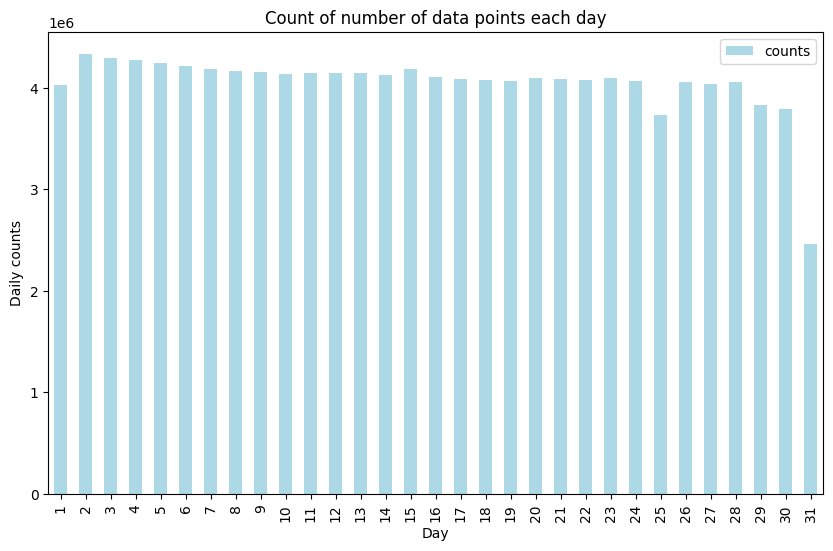

In [29]:
x_labels = daily_data['year'].values
fig = daily_data[['counts']].plot(kind='bar', facecolor='lightblue', figsize=(10, 6))
fig.set_xticklabels(x_labels)
fig.set_title('Count of number of data points each day')
fig.set_xlabel('Day')
fig.set_ylabel('Daily counts')
plt.show()

In [30]:
#Counting the total number of items
spark.sql('select COUNT(DISTINCT item_nbr) FROM data').show()

+------------------------+
|count(DISTINCT item_nbr)|
+------------------------+
|                    4036|
+------------------------+



In [31]:
#Total stores
spark.sql('select COUNT(DISTINCT store_nbr) FROM data').show()

+-------------------------+
|count(DISTINCT store_nbr)|
+-------------------------+
|                       54|
+-------------------------+



In [32]:
spark.sql('select EXTRACT(YEAR FROM date) as year, COUNT(DISTINCT item_nbr) as items FROM data  GROUP BY year ORDER BY year').show()

+----+-----+
|year|items|
+----+-----+
|2013| 1977|
|2014| 2885|
|2015| 3445|
|2016| 3886|
|2017| 4018|
+----+-----+



宇宙中的商品總數是：4036，我們可以看到他們銷售的商品數量每年都在增加，現在，2017 年我們總共有 4018 個商品，2016 年我們有 3886 個商品，2017 年有新商品推出其數據點可能較少，而且在測試集中已經說明我們有看不見的項目，我們需要在訓練或建模期間處理這些數據點。 此外，在我們的資料集中，我們可能有可能停止的項目，我們需要看看是否可以以某種方式找出這些項目，並在需要時將它們從整個訓練中刪除...

In [33]:
# Total Sales By Store
store_unit_sales = spark.sql('select store_nbr, SUM(unit_sales) as total_sales FROM data WHERE unit_sales > 0 GROUP BY store_nbr').toPandas()

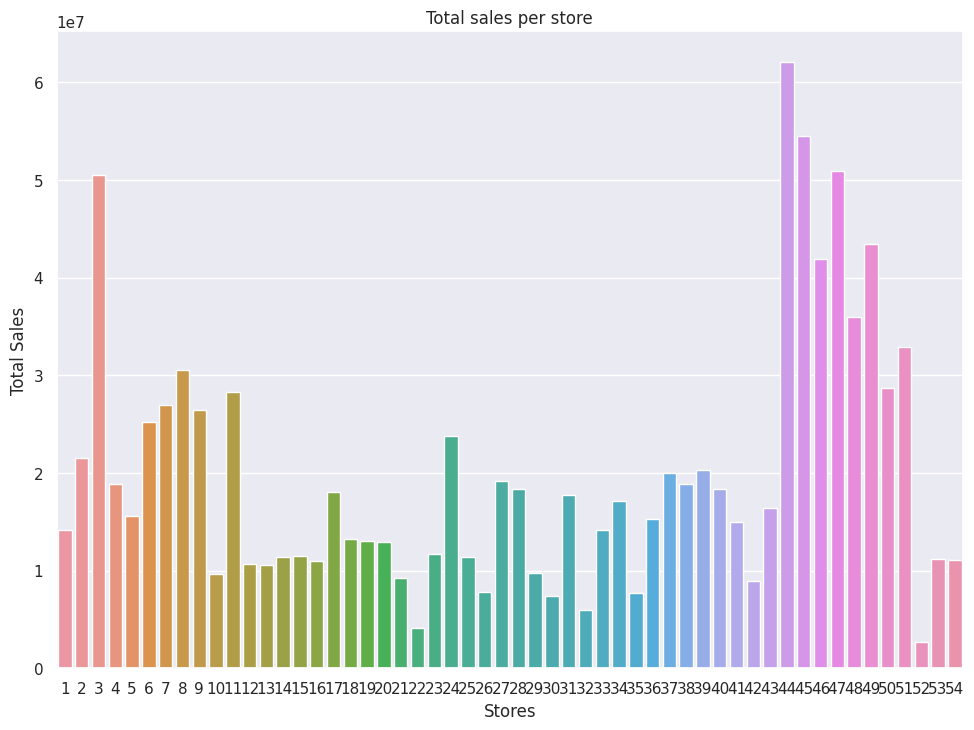

In [35]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='store_nbr', y='total_sales', data=store_unit_sales)
plt.title('Total sales per store')
plt.xlabel('Stores')
plt.ylabel('Total Sales')
plt.show()

In [9]:
sales_date_agg = spark.sql('select date, SUM(unit_sales) as total_sales FROM data WHERE unit_sales > 0 GROUP BY date ORDER BY date').toPandas()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Plot of total sales over time(daily)')

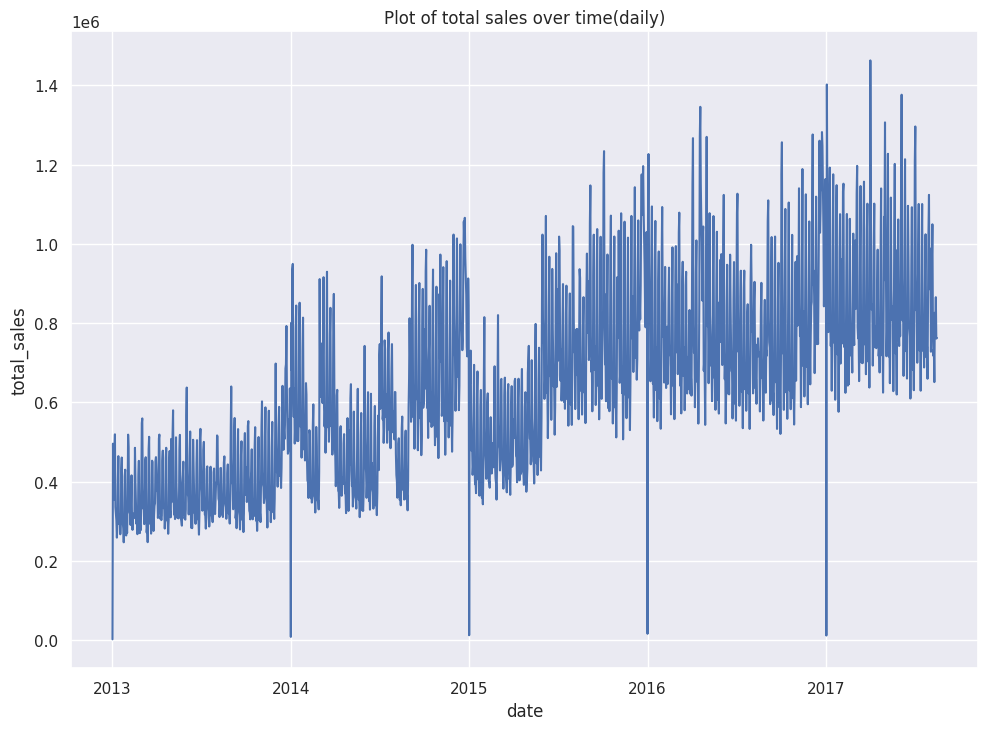

In [38]:
sns.lineplot(x=sales_date_agg['date'], y=sales_date_agg['total_sales'])
plt.title('Plot of total sales over time(daily)')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Plot of total sales over time(daily) for year 2015')

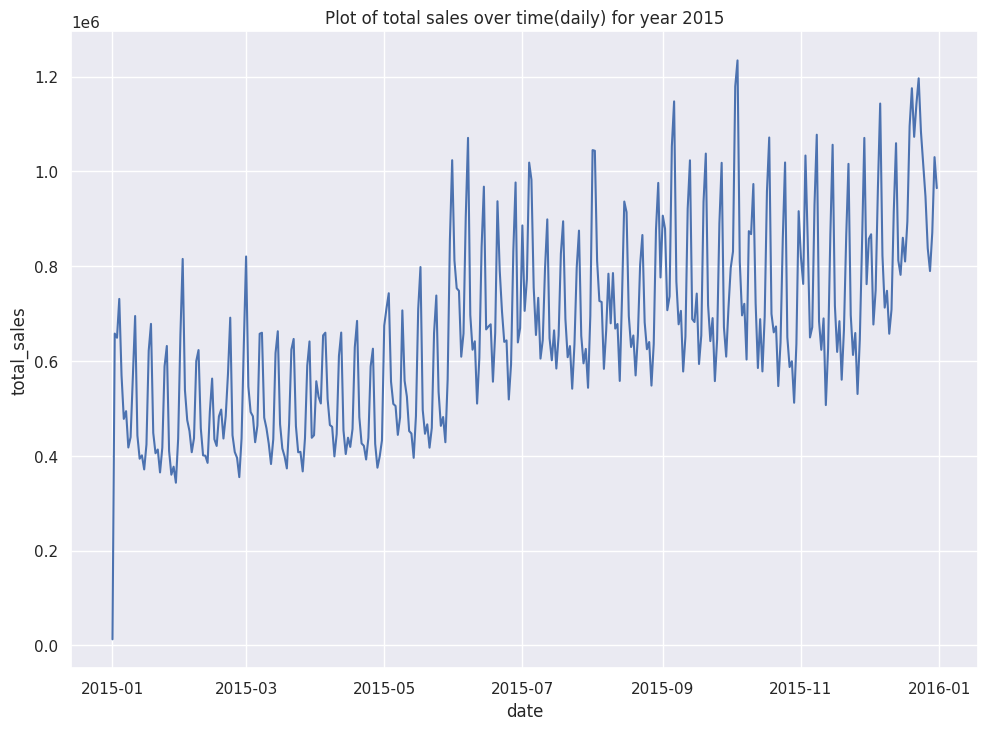

In [39]:
import datetime
start_index = sales_date_agg[sales_date_agg['date'] == datetime.date(2015, 1, 1)].index[0]
end_index = sales_date_agg[sales_date_agg['date'] == datetime.date(2015, 12, 31)].index[0]

year_2015_df = sales_date_agg.loc[start_index : end_index]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x=year_2015_df['date'], y=year_2015_df['total_sales'])
plt.title('Plot of total sales over time(daily) for year 2015')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Plot of total sales over time(daily) for year 2016')

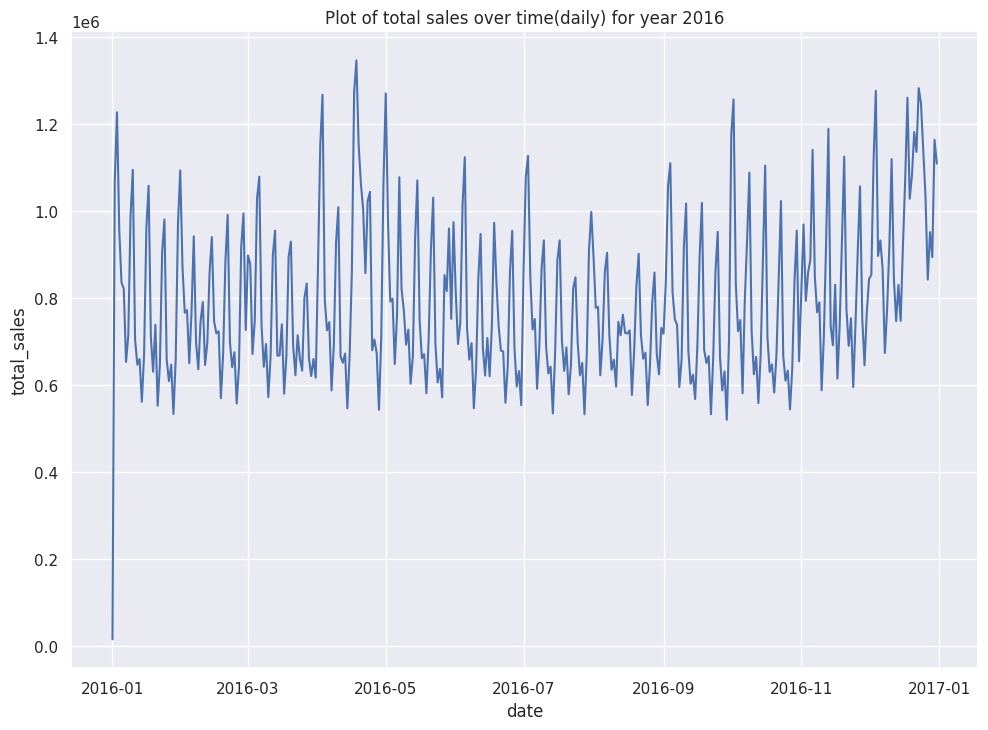

In [40]:
start_index = sales_date_agg[sales_date_agg['date'] == datetime.date(2016, 1, 1)].index[0]
end_index = sales_date_agg[sales_date_agg['date'] == datetime.date(2016, 12, 31)].index[0]

year_2016_df = sales_date_agg.loc[start_index : end_index]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x=year_2016_df['date'], y=year_2016_df['total_sales'])
plt.title('Plot of total sales over time(daily) for year 2016')

In [10]:
sales_date_agg['week'] = sales_date_agg['date'].apply(lambda x : x.isocalendar()[1])
sales_date_agg['month'] = sales_date_agg['date'].apply(lambda x : x.month)
sales_date_agg['year'] = sales_date_agg['date'].apply(lambda x : x.year)

In [11]:
sales_date_agg.tail()

,date,total_sales,week,month,year
1679,2017-08-11,826378.722066,32,8,2017
1680,2017-08-12,792660.676979,32,8,2017
1681,2017-08-13,865645.677076,32,8,2017
1682,2017-08-14,761217.406076,33,8,2017
1683,2017-08-15,762667.935923,33,8,2017


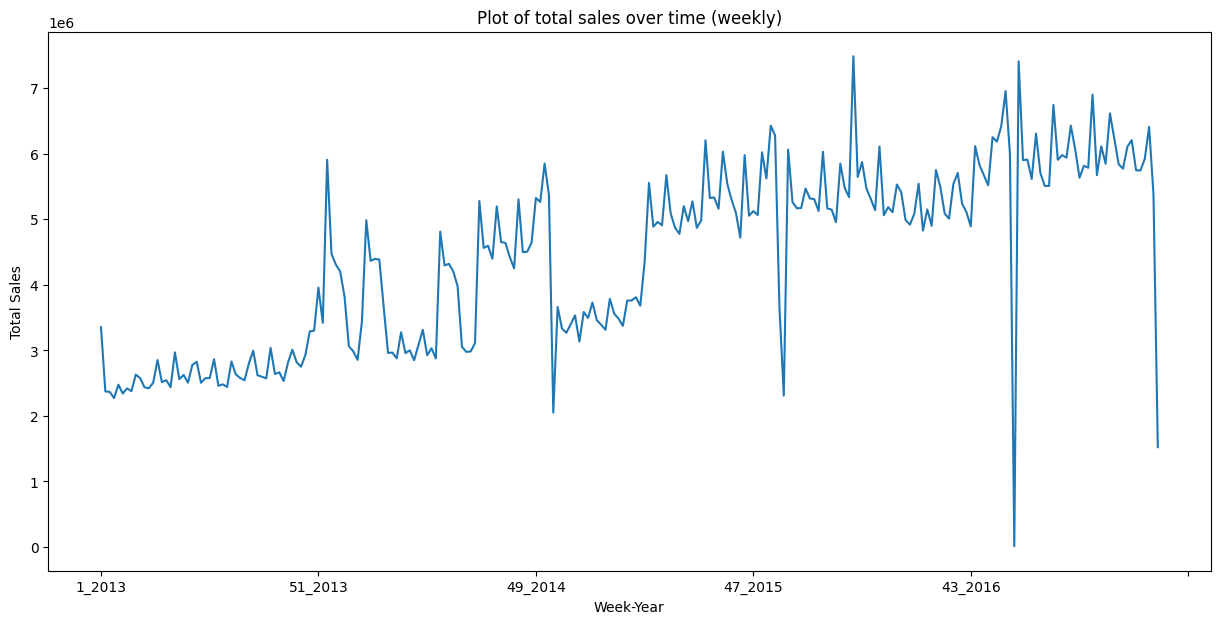

In [15]:
# 假设sales_date_agg是你的数据框架
sales_date_agg['week_year'] = sales_date_agg['week'].astype(str) + '_' + sales_date_agg['year'].astype(str)

fig, ax = plt.subplots(figsize=(15,7))
sales_date_agg.groupby('week_year', sort=False)['total_sales'].sum().plot(ax=ax)
plt.title('Plot of total sales over time (weekly)')
plt.xlabel('Week-Year')
plt.ylabel('Total Sales')
plt.show()

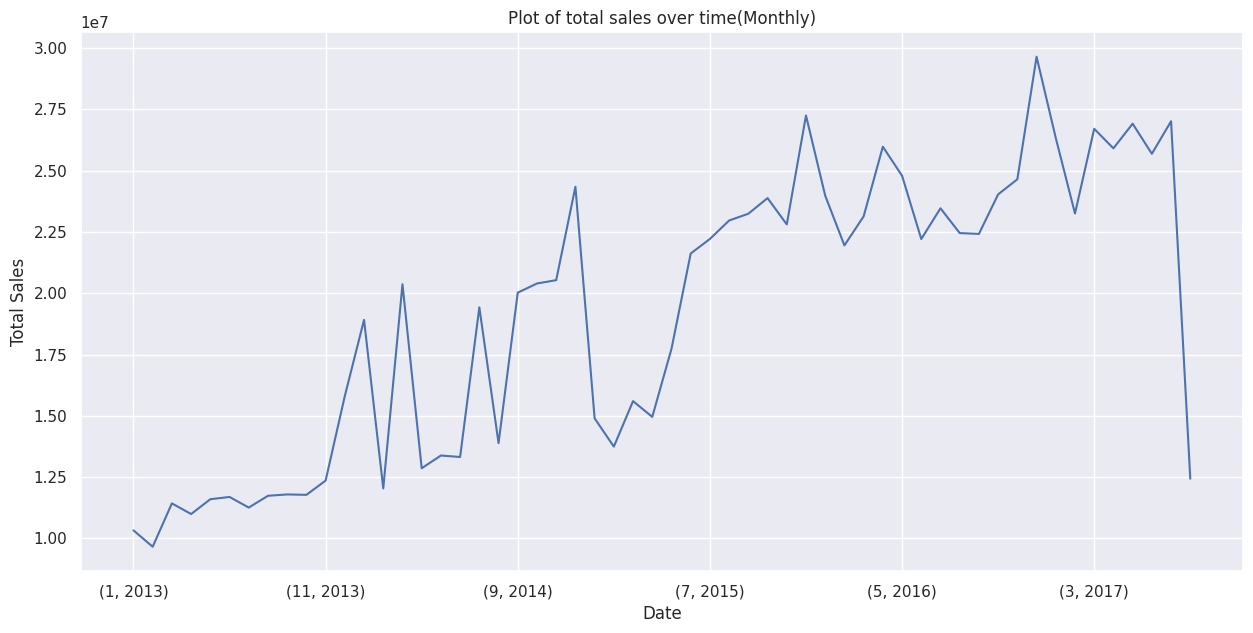

In [46]:
# 假设sales_date_agg是你的数据框架
sales_date_agg['date'] = pd.to_datetime(sales_date_agg['date'])  # 将日期列转换为datetime对象
sales_date_agg.set_index('date', inplace=True)  # 设置日期列为索引

fig, ax = plt.subplots(figsize=(15,7))
sales_date_agg.groupby([sales_date_agg.index.month, sales_date_agg.index.year], sort=False).sum()['total_sales'].plot(ax=ax)
plt.title('Plot of total sales over time(Monthly)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

In [47]:
# 查看特定商店隨時間變化的銷售額
date_store_level_data = spark.sql('select date, store_nbr, SUM(unit_sales) as sales_per_store FROM data  GROUP BY date, store_nbr ORDER BY date').toPandas()

隨機繪製了 10 家商店來檢查特定商店隨時間的銷售情況，我們確實看到少數商店有一些上升趨勢，但這可能是因為該商店正在銷售新商品，因此整體銷售額有所上升增加了，總體而言，大多數商店的模式都是相似的...

In [51]:
def plot_line_plot(x, y, txt):
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  sns.lineplot(x =x, y = y)
  plt.title(txt)
  plt.show()

store_list = list(date_store_level_data['store_nbr'].unique())

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


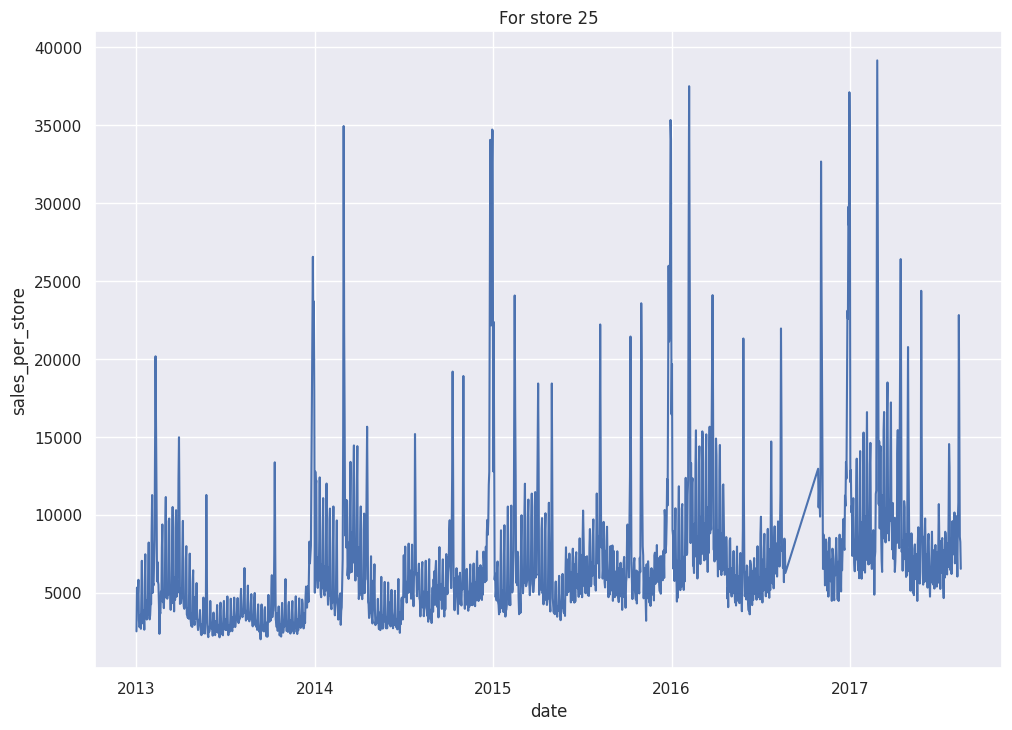

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


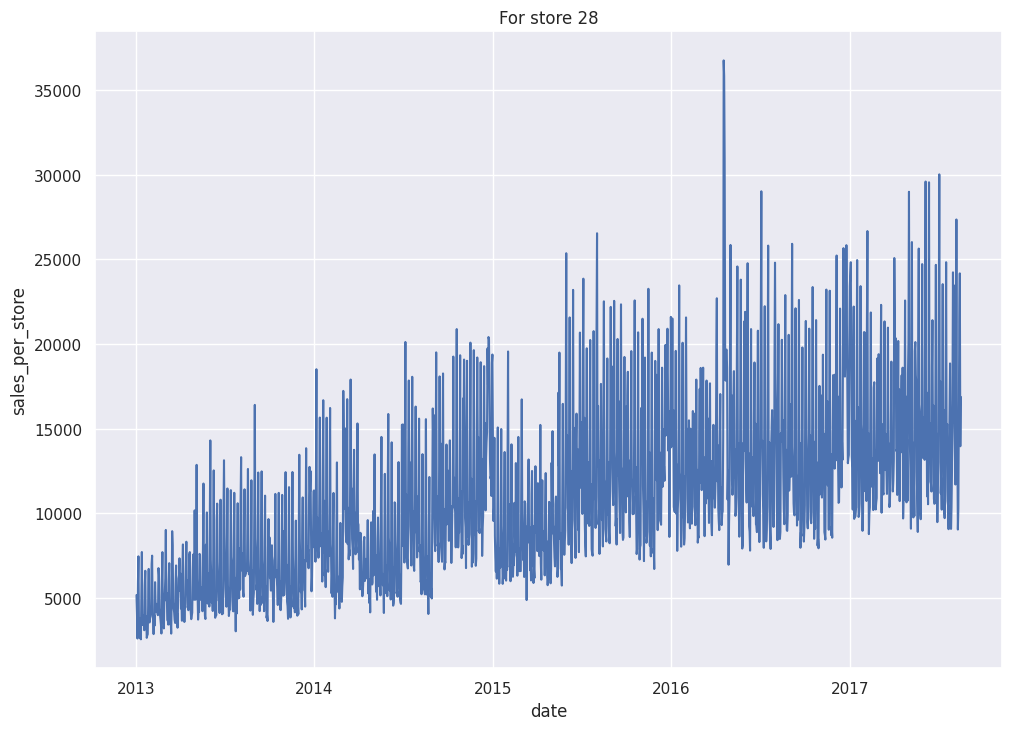

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


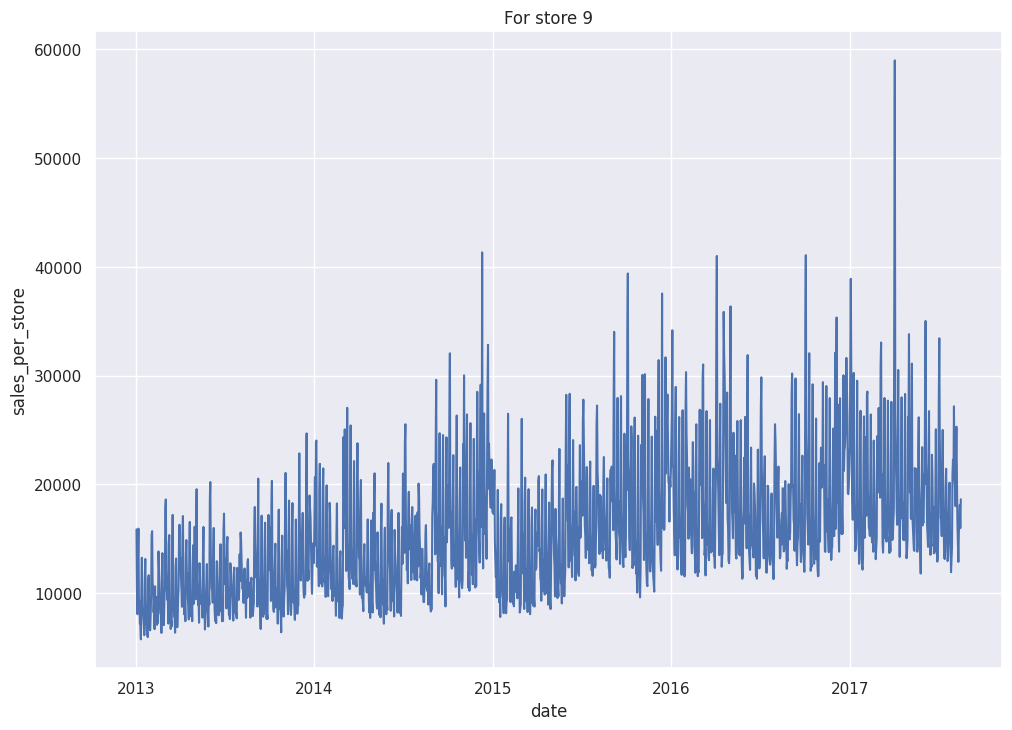

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


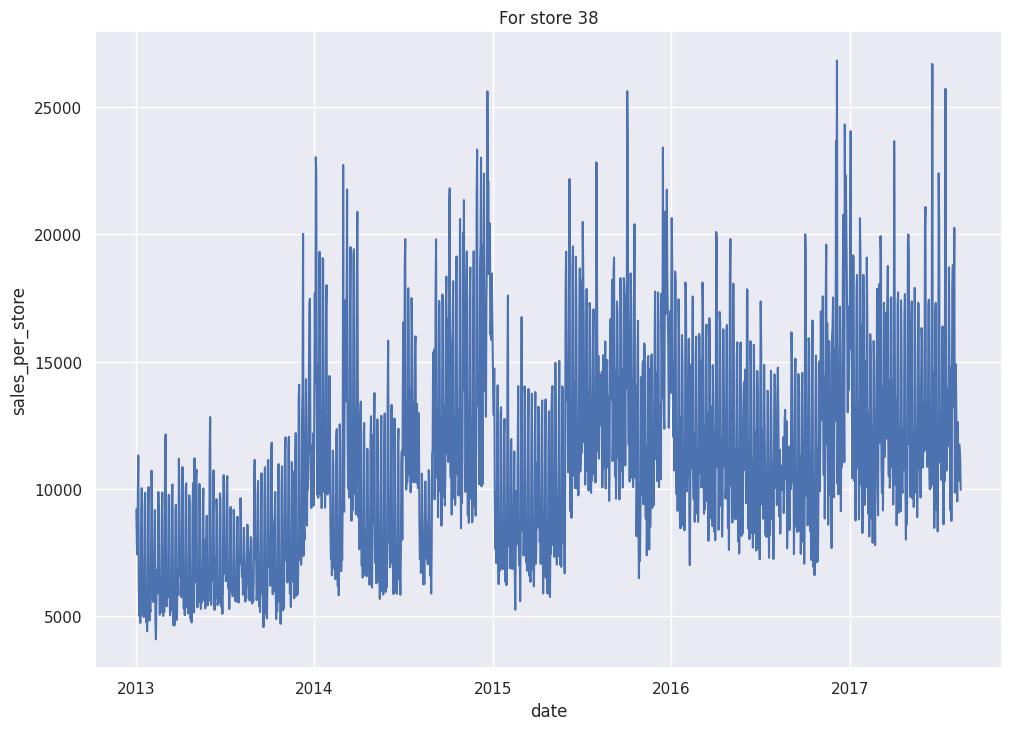

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


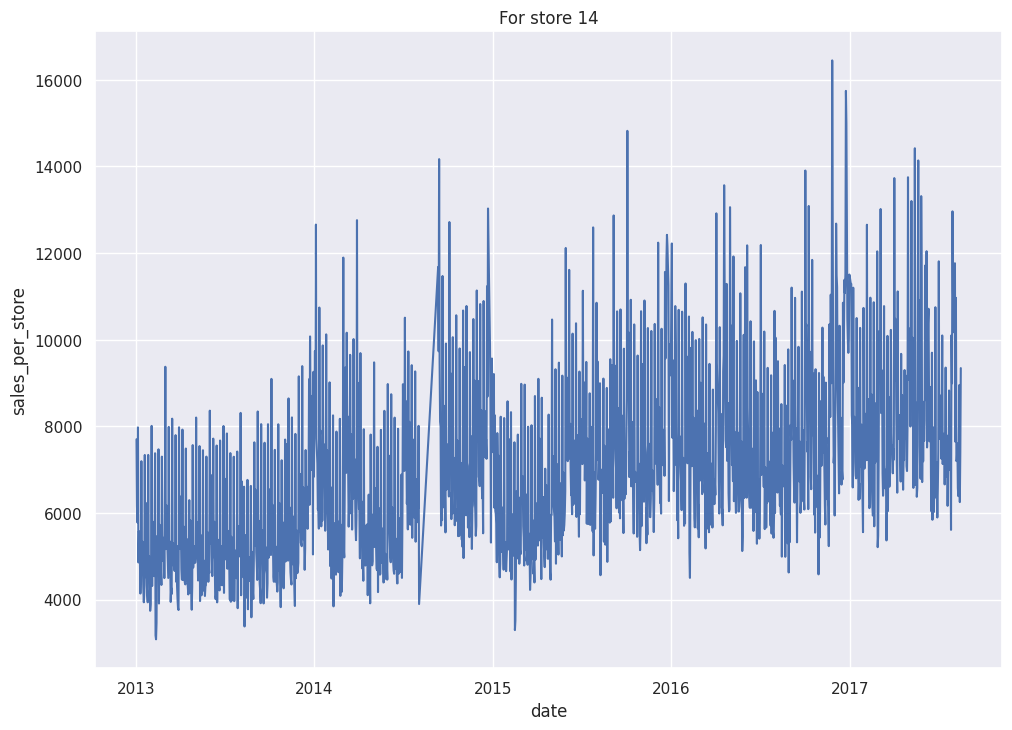

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


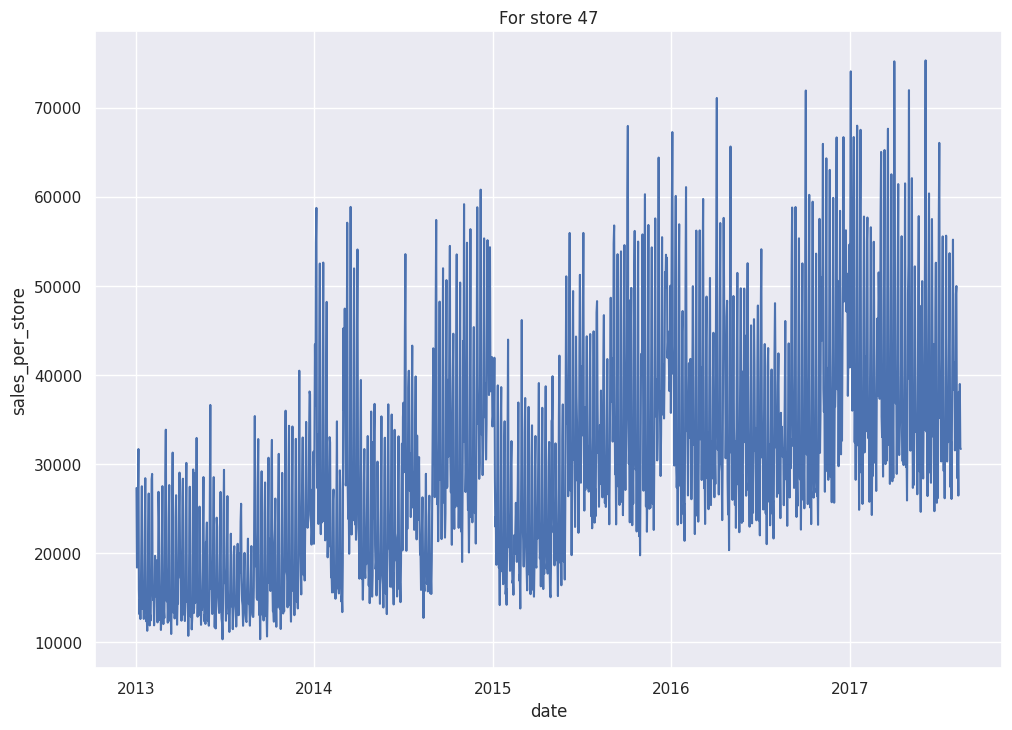

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


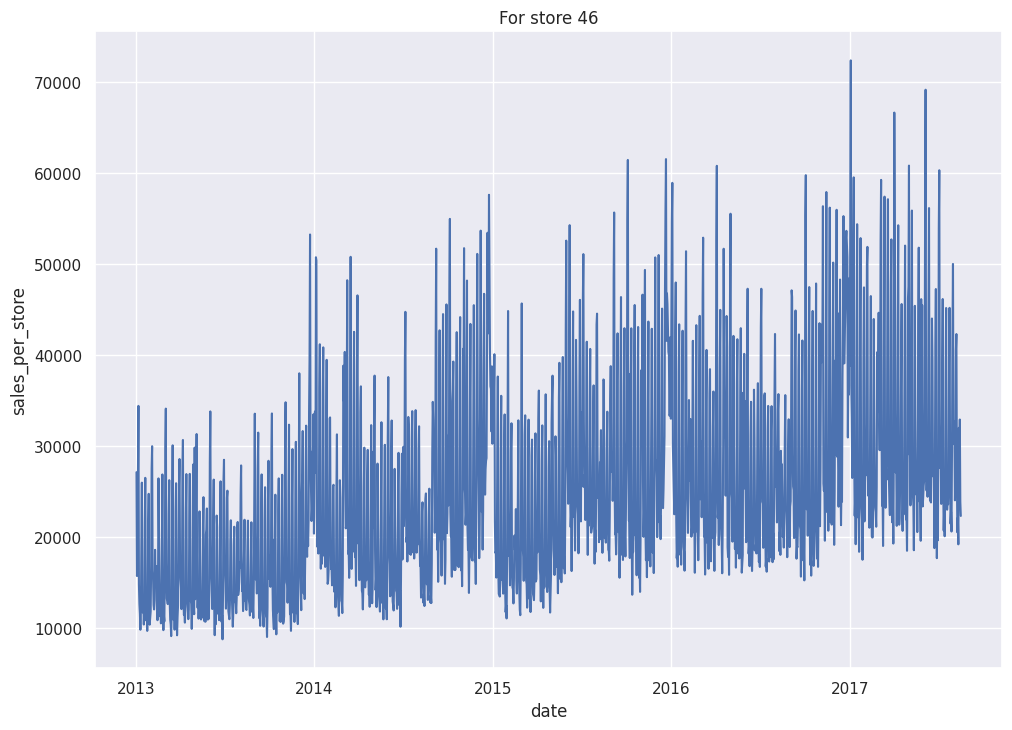

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


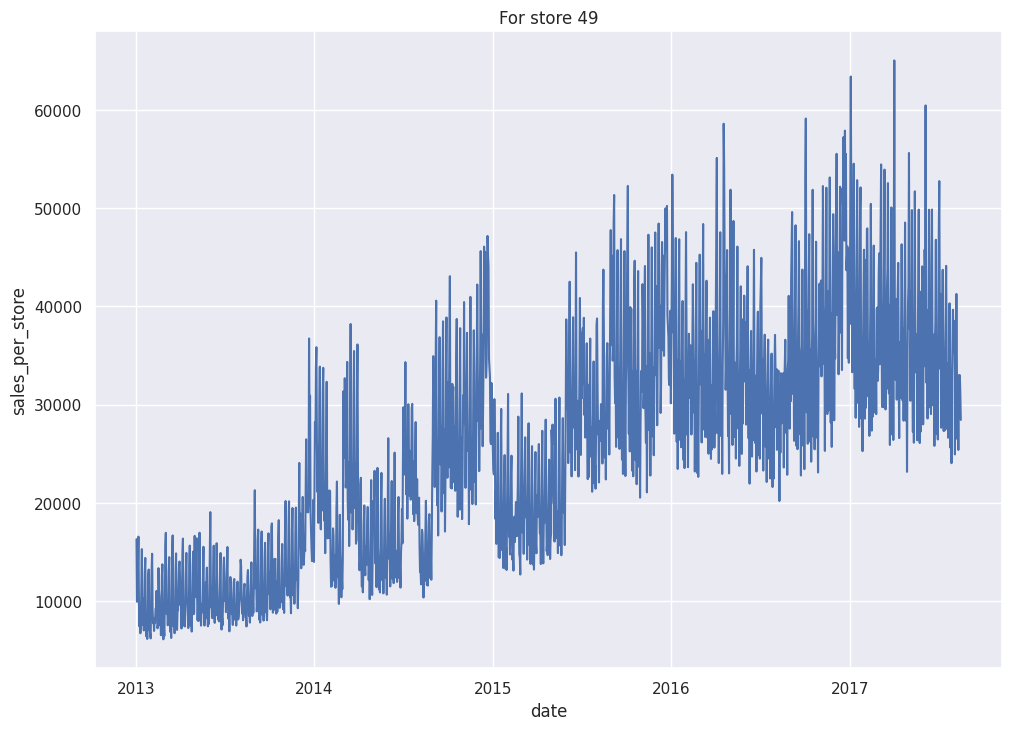

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


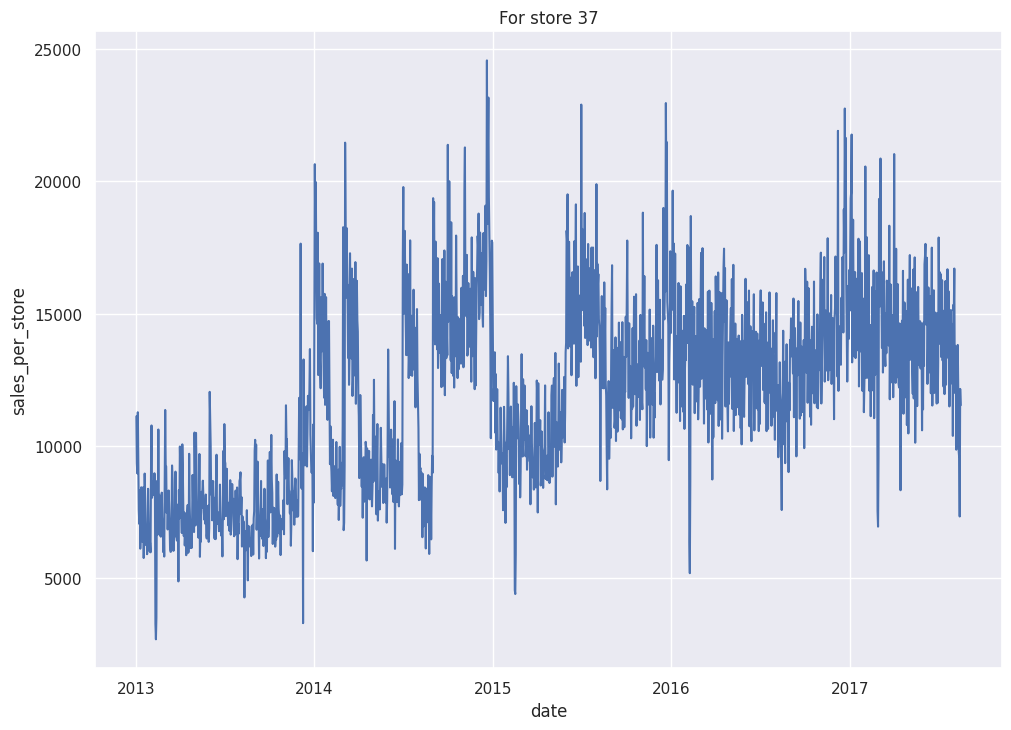

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


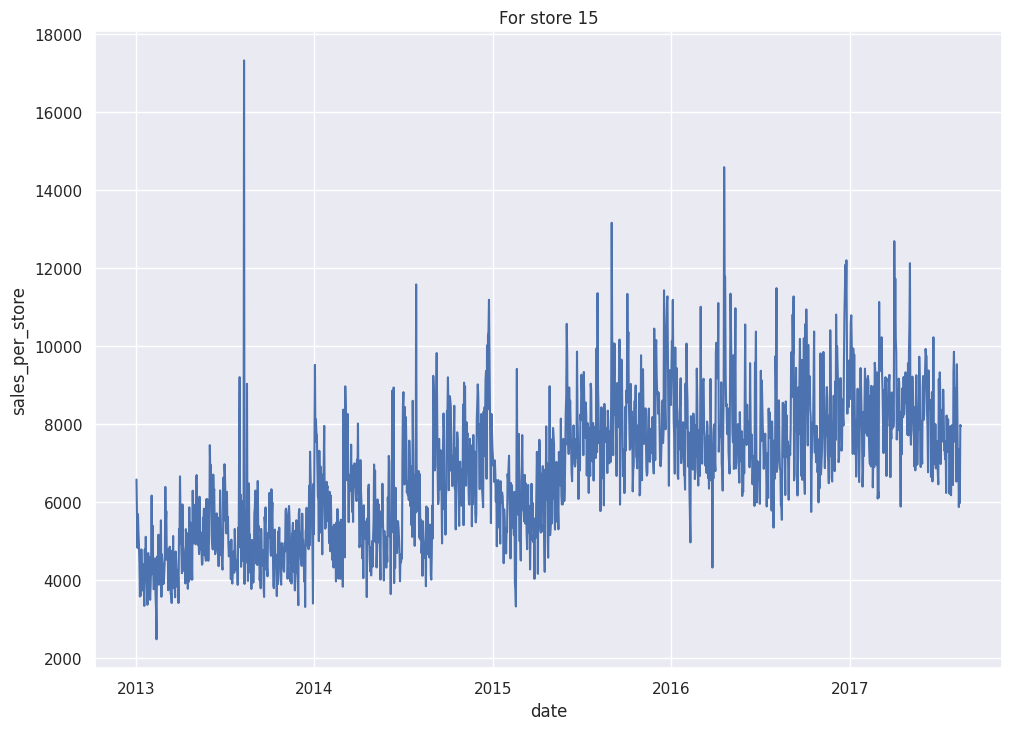

In [52]:
for i in range(10):
  plot_line_plot(date_store_level_data[date_store_level_data['store_nbr'] == store_list[i]]['date'], date_store_level_data[date_store_level_data['store_nbr'] == store_list[i]]['sales_per_store'], 'For store {}'.format(store_list[i]))

In [12]:
date_item_level_sales = spark.sql('select item_nbr, COUNT(unit_sales) as sales_per_item FROM data GROUP BY item_nbr').toPandas()

In [14]:
date_item_level_sales.loc[date_item_level_sales['item_nbr'] == 502331, 'sales_per_item'].iloc[0]

83475

### store.csv

In [15]:
stores_df.printSchema()

root
 |-- store_nbr: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: string (nullable = true)



In [16]:
stores_df = stores_df.withColumn('store_nbr', col('store_nbr').cast(IntegerType())) \
                     .withColumn('cluster', col('cluster').cast(IntegerType()))

In [17]:
stores_df.createOrReplaceTempView('store_data')
stores_df.cache

<bound method DataFrame.cache of DataFrame[store_nbr: int, city: string, state: string, type: string, cluster: int]>

In [18]:
store_type = spark.sql('select type, count(1) count FROM store_data GROUP BY type').toPandas()
store_city = spark.sql('select city, count(1) count FROM store_data GROUP BY city').toPandas()
store_state = spark.sql('select state, count(1) count FROM store_data GROUP BY state').toPandas()
store_cluster = spark.sql('select cluster, count(1) count FROM store_data GROUP BY cluster ORDER BY cluster').toPandas()

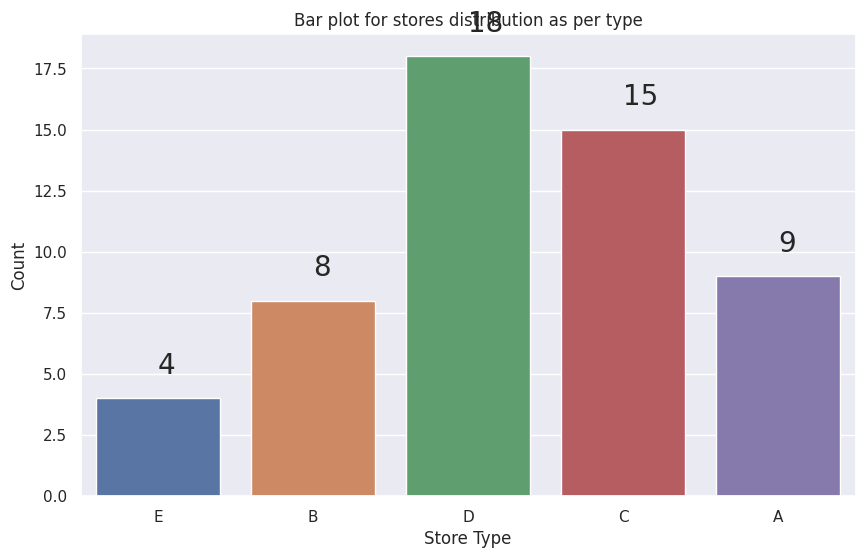

In [40]:
plt.figure(figsize=(10, 6))
x=store_type['type']
y=store_type['count']
sns.barplot(x=x, y=y)
for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20))
plt.title('Bar plot for stores distribution as per type')
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.show()

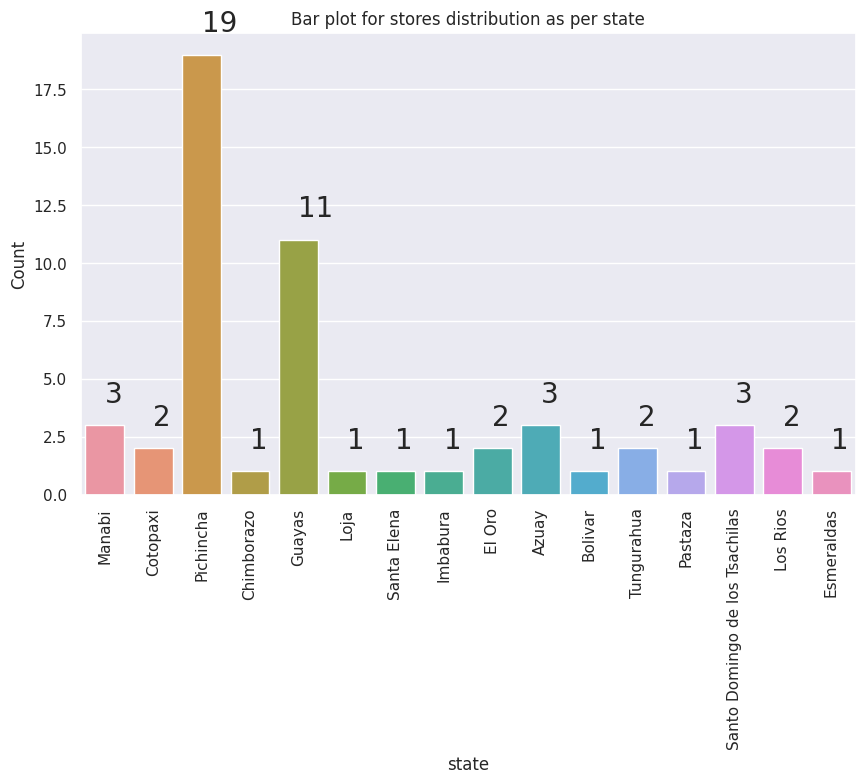

In [47]:
plt.figure(figsize=(10, 6))
x=store_state ['state']
y=store_state['count']
sns.barplot(x=x, y=y)
for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20))
plt.title('Bar plot for stores distribution as per state')
plt.xlabel('state')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

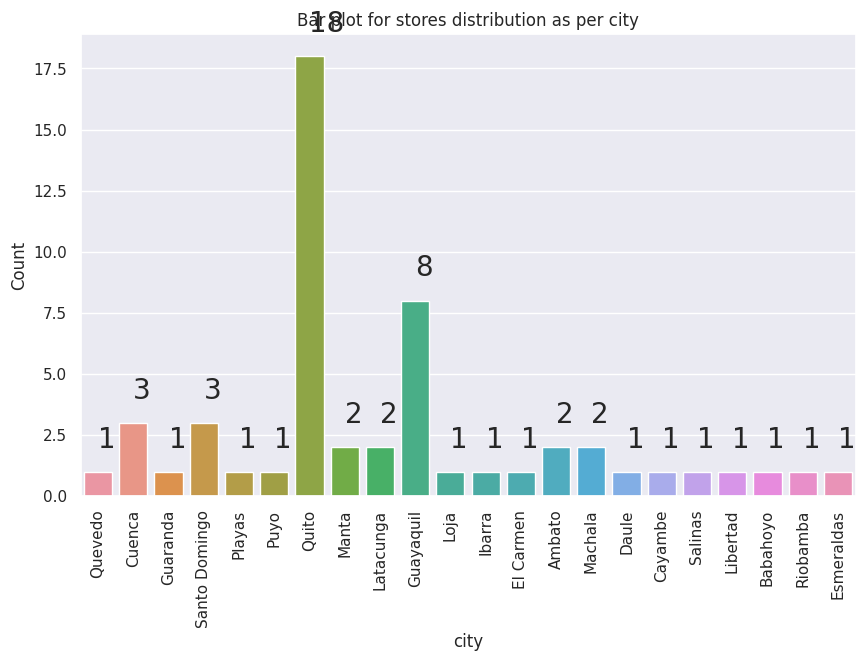

In [46]:
plt.figure(figsize=(10, 6))
x=store_city['city']
y=store_city['count']
sns.barplot(x=x, y=y)
for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20))
plt.title('Bar plot for stores distribution as per city')
plt.xlabel('city')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

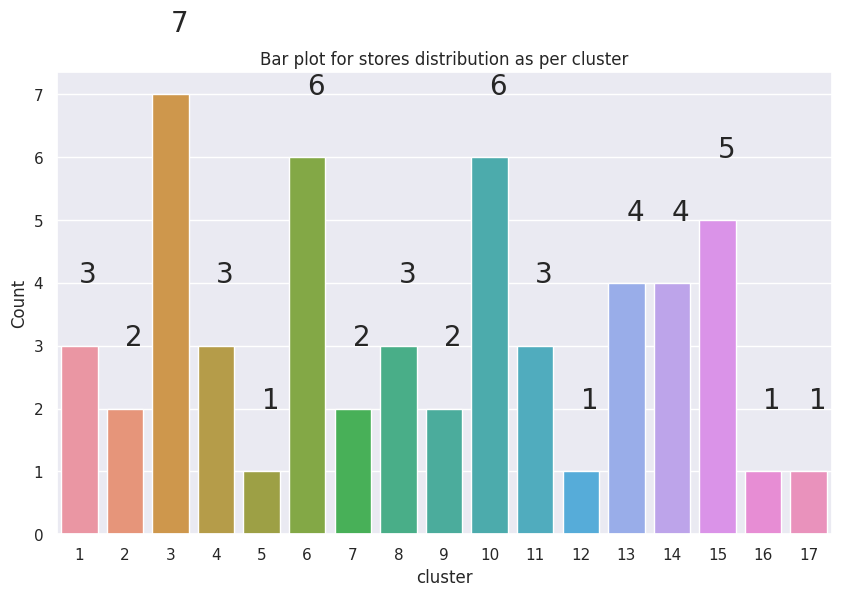

In [37]:
plt.figure(figsize=(10, 6))
x=store_cluster['cluster']
y=store_cluster['count']
sns.barplot(x=x, y=y)
for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20))
plt.title('Bar plot for stores distribution as per cluster')
plt.xlabel('cluster')
plt.ylabel('Count')
plt.show()

In [30]:
type_sales = spark.sql('''SELECT s.type, SUM(d.unit_sales) AS total_sales FROM data d LEFT JOIN store_data s ON d.store_nbr = s.store_nbr 
                          GROUP BY s.type ORDER BY total_sales DESC''').toPandas()

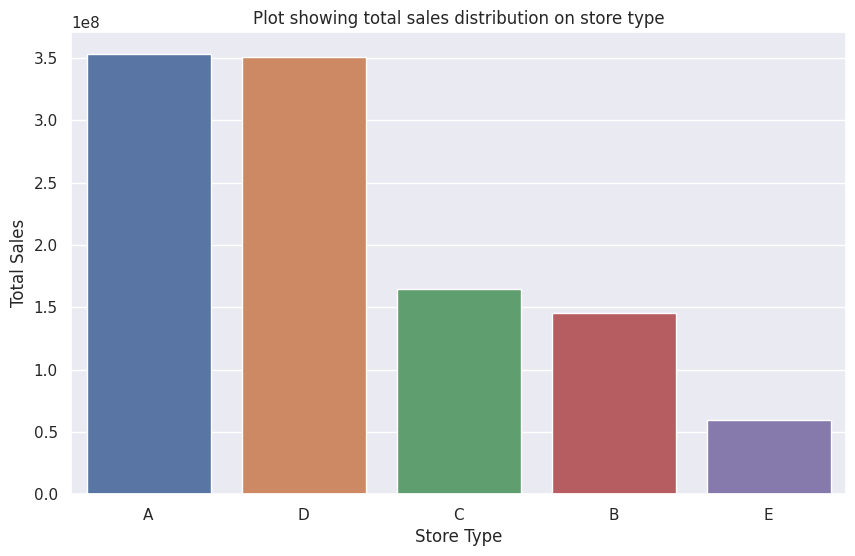

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(x=type_sales['type'], y=type_sales['total_sales'])
plt.title('Plot showing total sales distribution on store type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.show()

In [41]:
cluster_sales = spark.sql('select s.cluster, SUM(d.unit_sales) as total_sales from data d LEFT JOIN store_data s on d.store_nbr = s.store_nbr GROUP BY s.cluster ORDER BY total_sales DESC').toPandas()

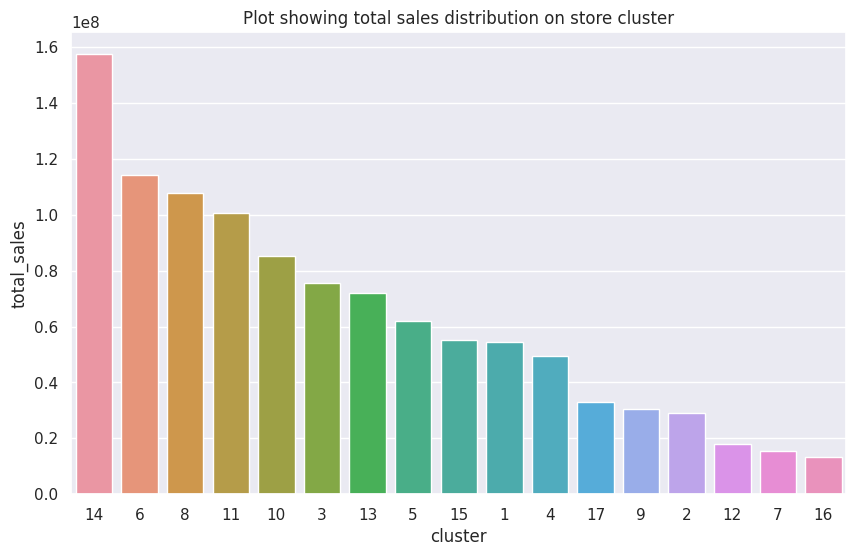

In [48]:
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_sales['cluster'], y=cluster_sales['total_sales'], \
            order=cluster_sales.sort_values('total_sales',ascending = False).cluster)
plt.title('Plot showing total sales distribution on store cluster')
plt.show()

In [43]:
state_sales = spark.sql('select s.state, SUM(d.unit_sales) as total_sales from data d LEFT JOIN store_data s on d.store_nbr = s.store_nbr GROUP BY s.state ORDER BY total_sales DESC').toPandas()

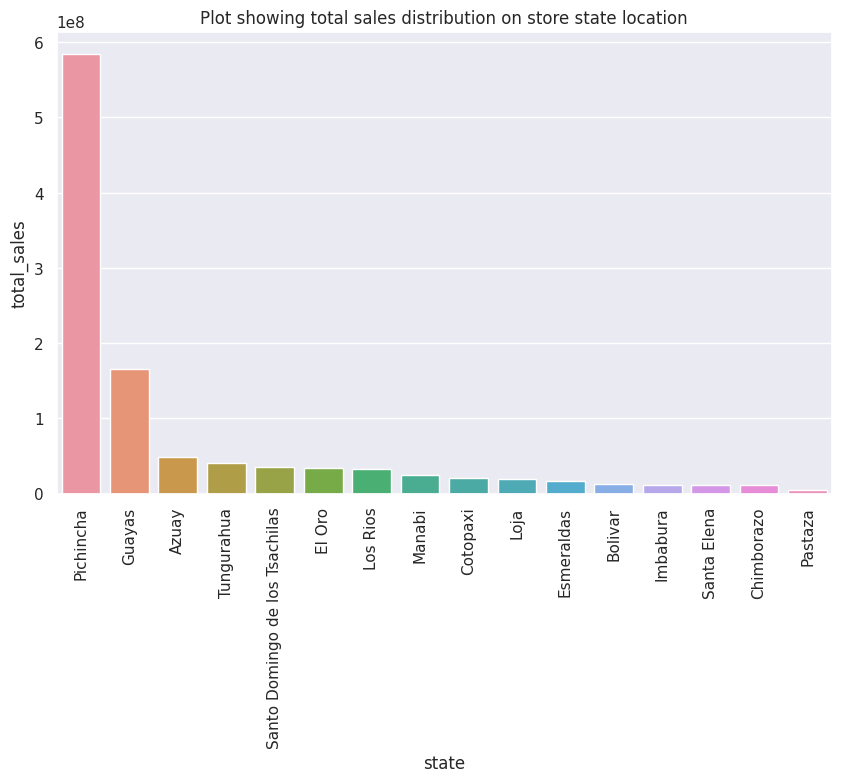

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(x=state_sales['state'], y=state_sales['total_sales'])
plt.title('Plot showing total sales distribution on store state location')
plt.xticks(rotation=90)
plt.show()

In [50]:
city_sales = spark.sql('select s.city, SUM(d.unit_sales) as total_sales from data d LEFT JOIN store_data s on d.store_nbr = s.store_nbr GROUP BY s.city ORDER BY total_sales DESC').toPandas()

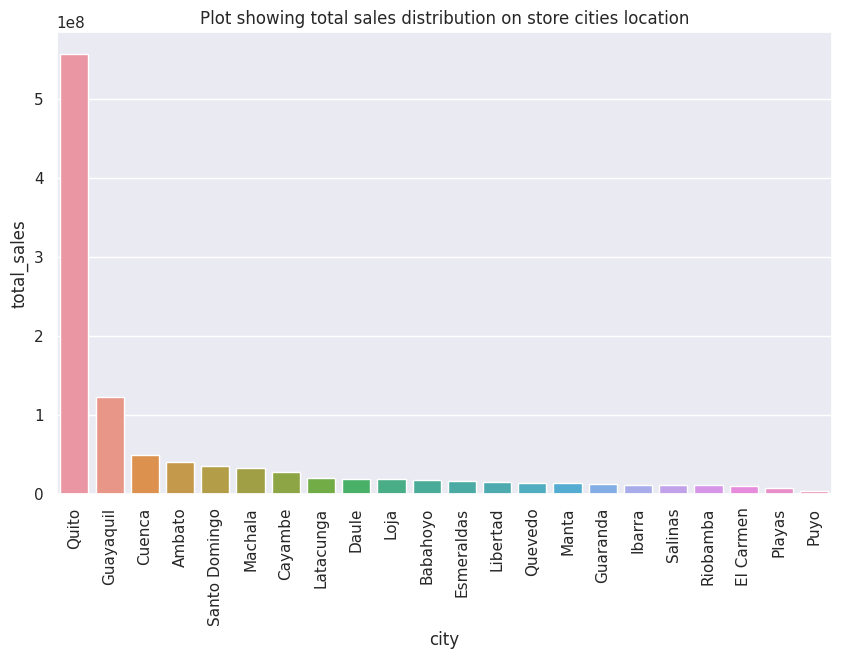

In [51]:
plt.figure(figsize=(10, 6))
sns.barplot(x=city_sales['city'], y=city_sales['total_sales'])
plt.title('Plot showing total sales distribution on store cities location')
plt.xticks(rotation=90)
plt.show()

### items.csv

In [52]:
items_df.printSchema()

root
 |-- item_nbr: string (nullable = true)
 |-- family: string (nullable = true)
 |-- class: string (nullable = true)
 |-- perishable: string (nullable = true)



In [53]:
items_df = items_df.withColumn('item_nbr', col('item_nbr').cast(IntegerType())) \
                   .withColumn('class', col('class').cast(IntegerType())) \
                   .withColumn('perishable', col('perishable').cast(IntegerType()))

In [54]:
items_df.createOrReplaceTempView('items_data')
items_df.cache

<bound method DataFrame.cache of DataFrame[item_nbr: int, family: string, class: int, perishable: int]>

In [55]:
spark.sql('select COUNT(DISTINCT item_nbr) as total_items from items_data').show()

+-----------+
|total_items|
+-----------+
|       4100|
+-----------+



Total items in the file is 4100, in train file we saw total items to be 4036, 64 may be the items in the test file whose details are not available in train.

In [56]:
spark.sql('select COUNT(DISTINCT family) as all_family from items_data').show()

+----------+
|all_family|
+----------+
|        33|
+----------+



In [57]:
spark.sql('select COUNT(DISTINCT class) as all_class from items_data').show()

+---------+
|all_class|
+---------+
|      337|
+---------+



In [58]:
spark.sql('select perishable, COUNT(1) as count from items_data GROUP BY perishable').show()

+----------+-----+
|perishable|count|
+----------+-----+
|         1|  986|
|         0| 3114|
+----------+-----+



In [60]:
spark.sql('SELECT perishable, count, ROUND(count/SUM(count) OVER (), 2) as percent FROM (select perishable, COUNT(1) as count from items_data GROUP BY perishable) ').show()

+----------+-----+-------+
|perishable|count|percent|
+----------+-----+-------+
|         1|  986|   0.24|
|         0| 3114|   0.76|
+----------+-----+-------+



24/04/06 07:30:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/06 07:30:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/06 07:30:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/06 07:30:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/06 07:30:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/06 07:30:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/06 0

In [61]:
# 每個family包含的item個數
spark.sql('select family, count(Distinct item_nbr) as item_count from items_data GROUP BY family ORDER BY item_count DESC').show()

+-------------------+----------+
|             family|item_count|
+-------------------+----------+
|          GROCERY I|      1334|
|          BEVERAGES|       613|
|           CLEANING|       446|
|            PRODUCE|       306|
|              DAIRY|       242|
|      PERSONAL CARE|       153|
|       BREAD/BAKERY|       134|
|          HOME CARE|       108|
|               DELI|        91|
|              MEATS|        84|
| HOME AND KITCHEN I|        77|
|   LIQUOR,WINE,BEER|        73|
|       FROZEN FOODS|        55|
|            POULTRY|        54|
|HOME AND KITCHEN II|        45|
|               EGGS|        41|
|        CELEBRATION|        31|
|     PREPARED FOODS|        26|
|    LAWN AND GARDEN|        26|
|         LADIESWEAR|        21|
+-------------------+----------+
only showing top 20 rows



In [62]:
itm_family = spark.sql('select family, count(Distinct item_nbr) as item_count from items_data GROUP BY family ORDER BY item_count DESC').toPandas()

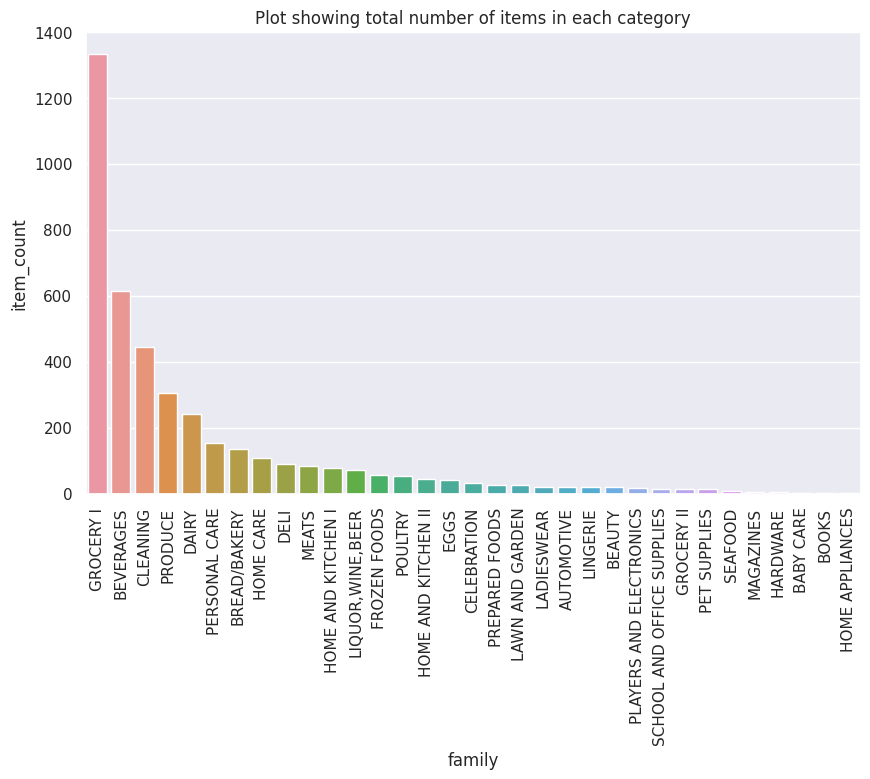

In [63]:
plt.figure(figsize=(10, 6))
sns.barplot(x=itm_family['family'], y=itm_family['item_count'])
plt.title('Plot showing total number of items in each category')
plt.xticks(rotation=90)
plt.show()

In [64]:
item_class_count = spark.sql('select class, count(Distinct item_nbr) as item_count from items_data GROUP BY class ORDER BY item_count DESC').toPandas()

In [65]:
item_class_count[item_class_count['item_count'] <=  2]['class'].nunique()

118

Checking relationship between classes and family

In [66]:
class_family_item_group = spark.sql('select class, family, count(DISTINCT item_nbr) as item_count FROM items_data GROUP BY class, family').toPandas()

In [68]:
class_family_item_group[class_family_item_group['family'] == 'GROCERY I']

,class,family,item_count
1,1079,GROCERY I,1
5,1058,GROCERY I,16
11,1054,GROCERY I,2
13,1076,GROCERY I,23
16,1024,GROCERY I,4
...,...,...,...
302,1045,GROCERY I,24
306,1096,GROCERY I,18
309,1029,GROCERY I,1
319,1067,GROCERY I,2


Have checked for various families, and now it is known that classes are the sub group of families, but this is the only info we have, combining with other data present will tell us of the predictive importance of this data.

### transactions.csv

In [16]:
transactions_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- store_nbr: string (nullable = true)
 |-- transactions: string (nullable = true)



In [17]:
transactions_df = transactions_df.withColumn('date', col('date').cast(DateType())) \
                                 .withColumn('store_nbr', col('store_nbr').cast(IntegerType())) \
                                 .withColumn('transactions', col('transactions').cast(IntegerType()))

In [18]:
transactions_df.printSchema()

root
 |-- date: date (nullable = true)
 |-- store_nbr: integer (nullable = true)
 |-- transactions: integer (nullable = true)



In [19]:
transactions_df.createOrReplaceTempView('transactions_data')
transactions_df.cache

<bound method DataFrame.cache of DataFrame[date: date, store_nbr: int, transactions: int]>

In [20]:
transaction_date_agg = spark.sql('select date, SUM(transactions) as total_transaction FROM transactions_data GROUP BY date ORDER BY date').toPandas()

In [21]:
transaction_date_agg.tail()

,date,total_transaction
1677,2017-08-11,89551
1678,2017-08-12,89927
1679,2017-08-13,85993
1680,2017-08-14,85448
1681,2017-08-15,86561


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Plot of total transactions over time(daily)')

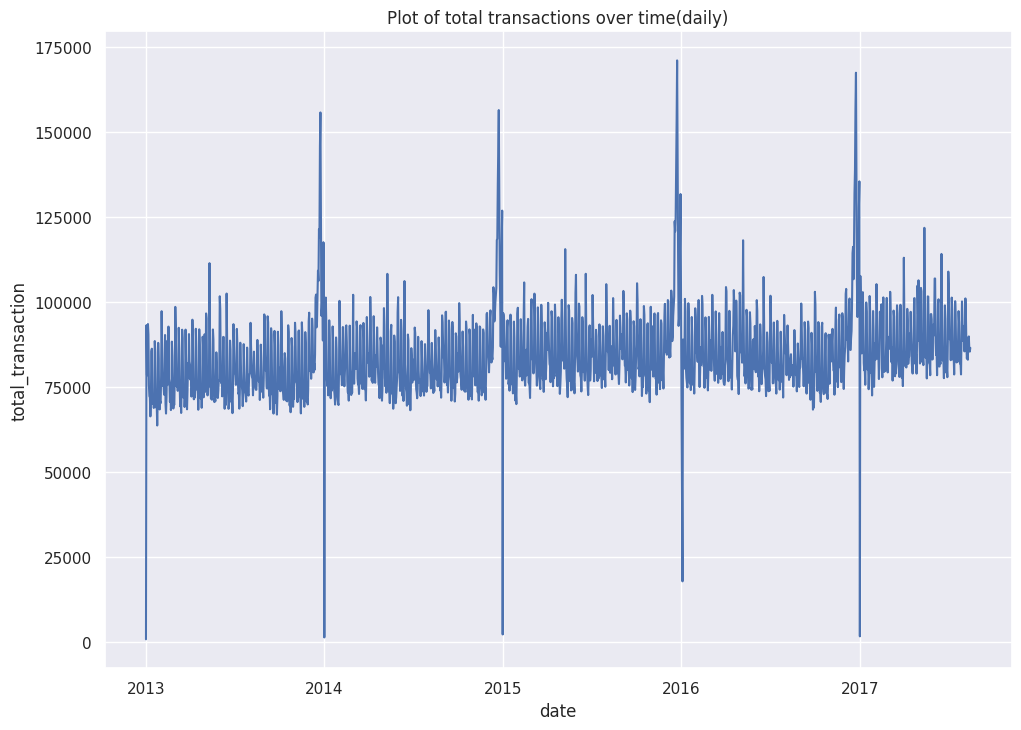

In [86]:
sns.lineplot(x=transaction_date_agg['date'], y=transaction_date_agg['total_transaction'])
plt.title('Plot of total transactions over time(daily)')

我們發現聖誕節前有一個強勁的高峰，而當商店在假期期間可能關門時，銷量就會相應下降。

總體而言，整個時間範圍內的銷售額似乎保持穩定。

Plotting for year 2015

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Plot of total transactions over time(daily) for year 2015')

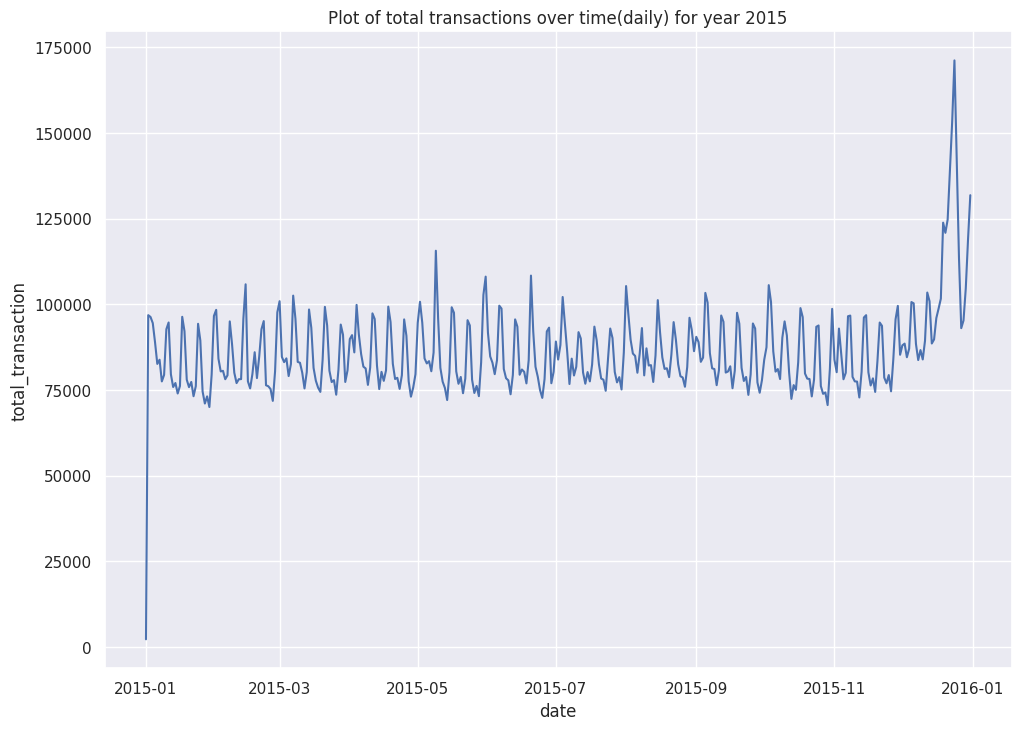

In [87]:
import datetime
start_index = transaction_date_agg[transaction_date_agg['date'] == datetime.date(2015, 1, 1)].index[0]
end_index = transaction_date_agg[transaction_date_agg['date'] == datetime.date(2015, 12, 31)].index[0]

year_2015_df = transaction_date_agg.loc[start_index : end_index]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x=year_2015_df['date'], y=year_2015_df['total_transaction'])
plt.title('Plot of total transactions over time(daily) for year 2015')

Let us aggragate date weekly and monthly and see how our plot looks like...

In [88]:
transaction_date_agg['week'] = transaction_date_agg['date'].apply(lambda x : x.isocalendar()[1])
transaction_date_agg['month'] = transaction_date_agg['date'].apply(lambda x : x.month)
transaction_date_agg['year'] = transaction_date_agg['date'].apply(lambda x : x.year)

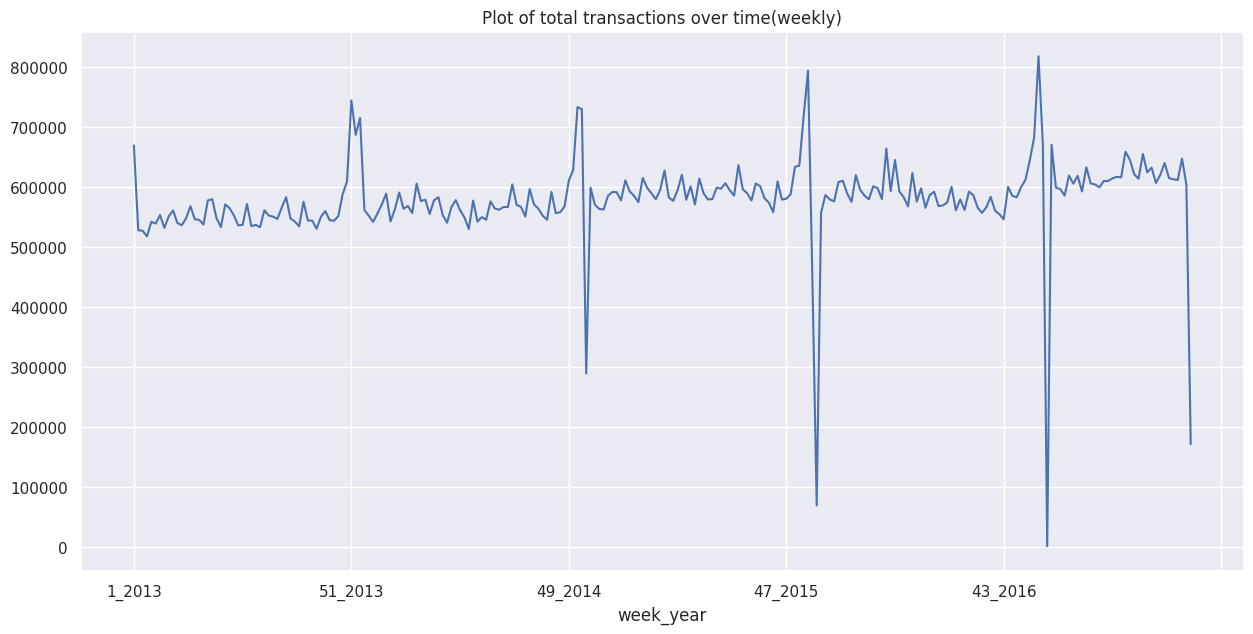

In [91]:
# 假设sales_date_agg是你的数据框架
transaction_date_agg['week_year'] = transaction_date_agg['week'].astype(str) + '_' + transaction_date_agg['year'].astype(str)

fig, ax = plt.subplots(figsize=(15,7))
transaction_date_agg.groupby('week_year', sort=False)['total_transaction'].sum().plot(ax=ax)
plt.title('Plot of total transactions over time(weekly)')
plt.show()

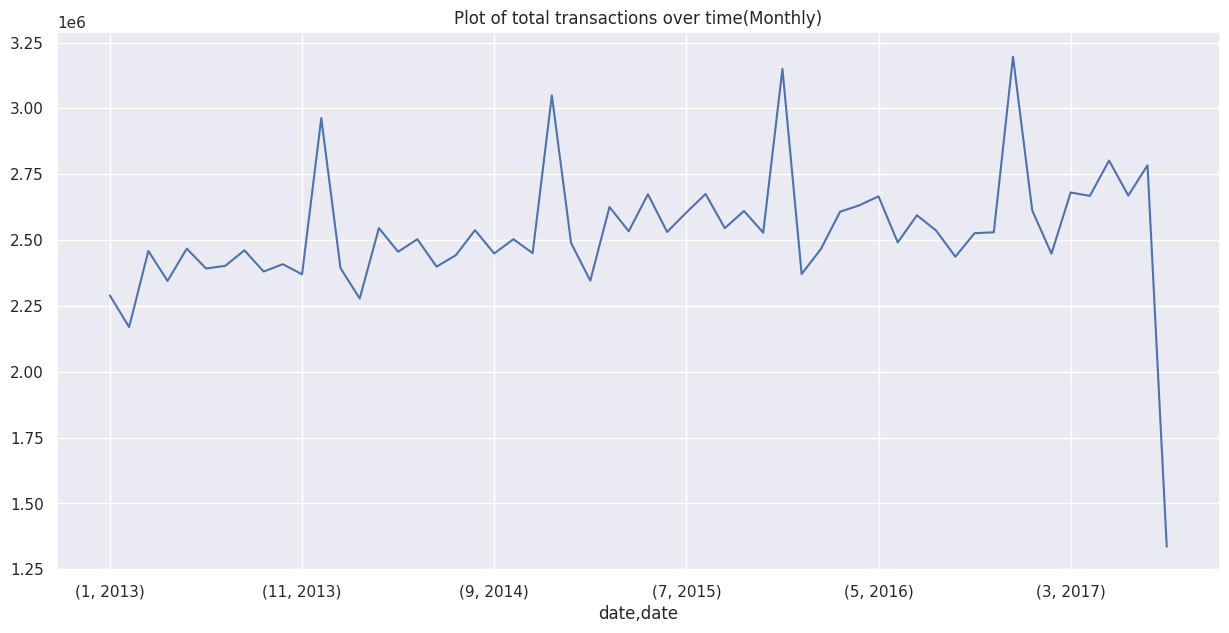

In [93]:
# 假设sales_date_agg是你的数据框架
transaction_date_agg['date'] = pd.to_datetime(transaction_date_agg['date'])  # 将日期列转换为datetime对象
transaction_date_agg.set_index('date', inplace=True)  # 设置日期列为索引

fig, ax = plt.subplots(figsize=(15,7))
transaction_date_agg.groupby([transaction_date_agg.index.month, transaction_date_agg.index.year], sort=False).sum()['total_transaction'].plot(ax=ax)
plt.title('Plot of total transactions over time(Monthly)')
plt.show()

Let us check the number of items purchased per transaction over the period

In [96]:
spark.sql('''SELECT transactions_data.date,  total_sales/total_transaction as items_per_transaction 
FROM 
(select date, SUM(transactions) as total_transaction FROM transactions_data GROUP BY date ORDER BY date) as transactions_data 
INNER JOIN 
(select date, SUM(unit_sales) as total_sales FROM data WHERE unit_sales > 0 GROUP BY date ORDER BY date) as data 
ON transactions_data.date=data.date
ORDER BY transactions_data.date''').show()

+----------+---------------------+
|      date|items_per_transaction|
+----------+---------------------+
|2013-01-01|   3.2618428574754046|
|2013-01-02|    5.322055656274635|
|2013-01-03|    4.604699264327097|
|2013-01-04|    4.515914503734317|
|2013-01-05|    5.101440811699174|
|2013-01-06|   5.7447758334714205|
|2013-01-07|    4.446258463242334|
|2013-01-08|    4.401656107473159|
|2013-01-09|    4.204051757270201|
|2013-01-10|   3.9020080897907308|
|2013-01-11|    4.122575066501422|
|2013-01-12|    4.715922068776316|
|2013-01-13|   5.3836181497208795|
|2013-01-14|   4.1905642571400055|
|2013-01-15|    4.205858662957437|
|2013-01-16|    4.392895157657377|
|2013-01-17|   3.8839387852835032|
|2013-01-18|    4.149216559139545|
|2013-01-19|    4.883430655618284|
|2013-01-20|    5.406747682204343|
+----------+---------------------+
only showing top 20 rows



In [97]:
items_per_transaction_df = spark.sql('''SELECT transactions_data.date,  total_sales/total_transaction as items_per_transaction 
FROM 
(select date, SUM(transactions) as total_transaction FROM transactions_data GROUP BY date ORDER BY date) as transactions_data 
INNER JOIN 
(select date, SUM(unit_sales) as total_sales FROM data WHERE unit_sales > 0 GROUP BY date ORDER BY date) as data 
ON transactions_data.date=data.date
ORDER BY transactions_data.date''').toPandas()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Plot for items purchased per transaction')

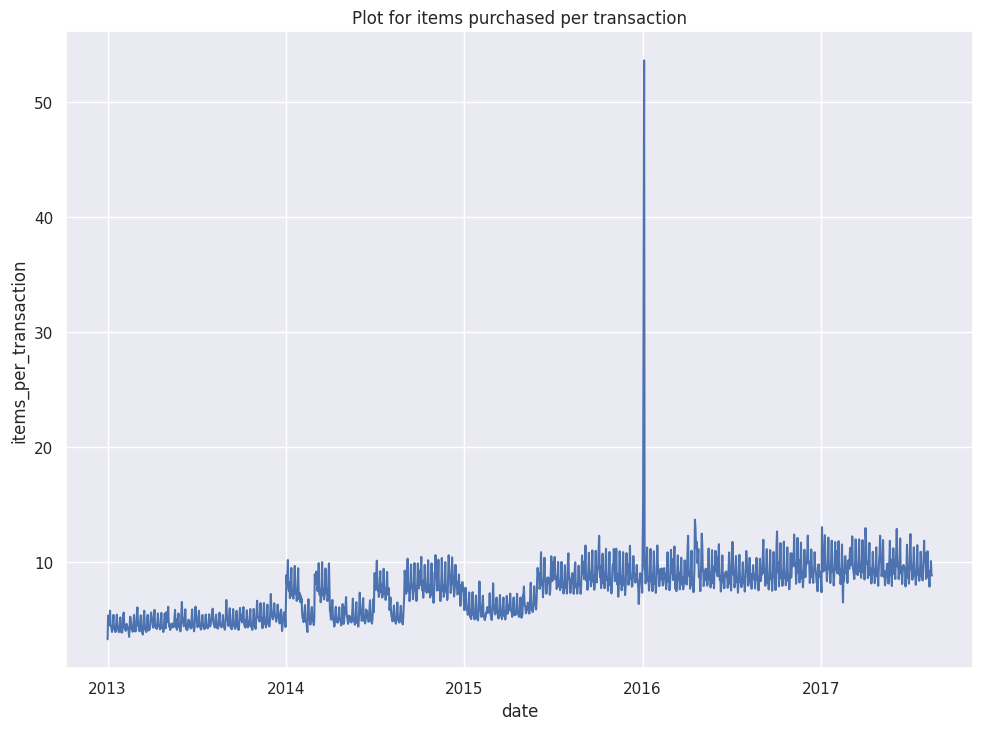

In [98]:
sns.lineplot(x=items_per_transaction_df['date'], y=items_per_transaction_df['items_per_transaction'])
plt.title('Plot for items purchased per transaction')

每筆交易購買的商品數量呈現小幅上升趨勢，這可能是由於商品數量隨著時間的推移而增加，此外，我們看到一個大的峰值，這可能是一個異常點，但總的來說似乎是一個很好的訊號...

Text(0.5, 1.0, 'Distribution of total transactions')

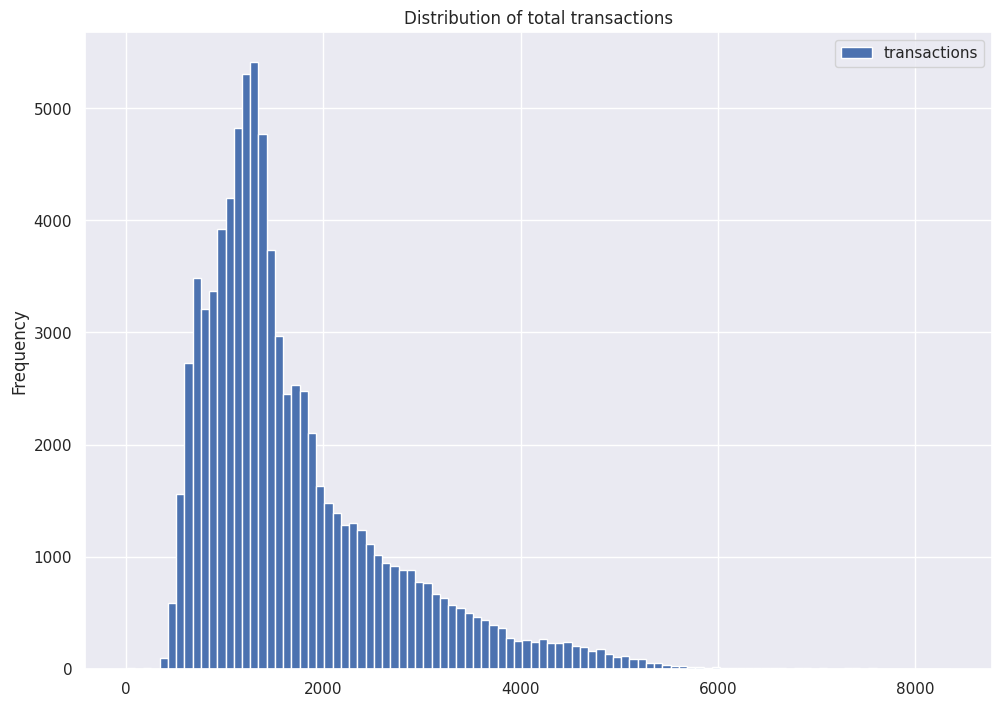

In [100]:
spark.sql('select transactions from transactions_data').toPandas().plot.hist(bins = 100)
plt.title('Distribution of total transactions')

### oil.csv

In [115]:
oil_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- dcoilwtico: string (nullable = true)



In [102]:
oil_df = oil_df.withColumn('date', col('date').cast(DateType())).withColumn('dcoilwtico', col('dcoilwtico').cast(FloatType()))

In [103]:
oil_df.dtypes

[('date', 'date'), ('dcoilwtico', 'float')]

In [104]:
oil_df.createOrReplaceTempView('oil_data')
oil_df.cache

<bound method DataFrame.cache of DataFrame[date: date, dcoilwtico: float]>

In [105]:
oil_df = spark.sql('select date, dcoilwtico from oil_data').toPandas()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Plot of oil prices over time')

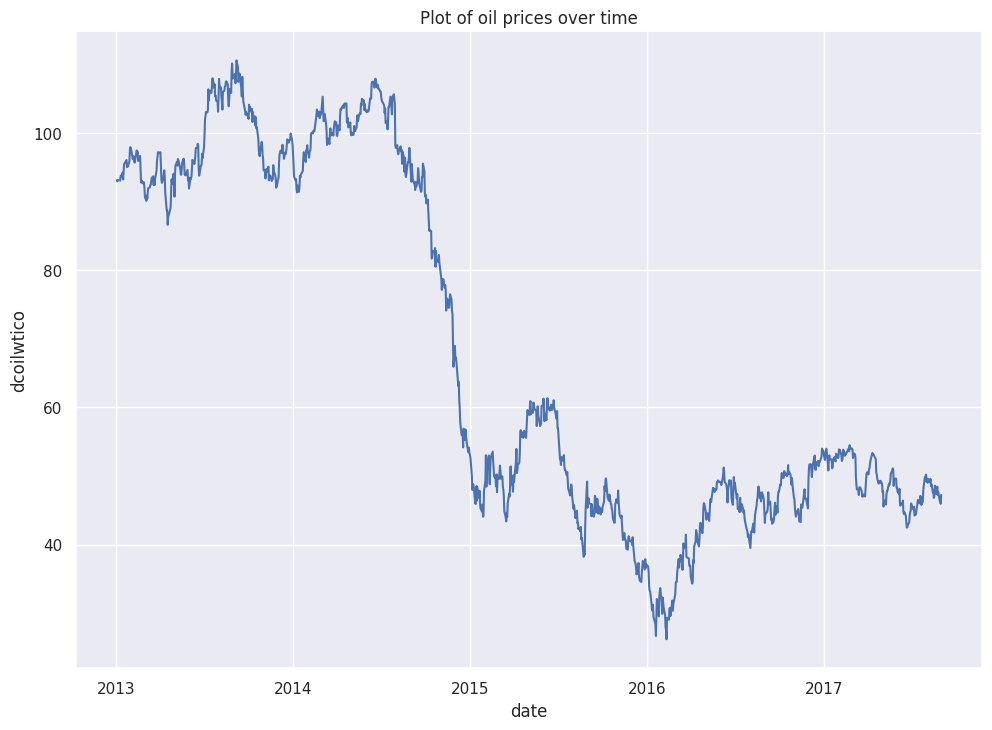

In [106]:
sns.lineplot(x=oil_df['date'], y=oil_df['dcoilwtico'])
plt.title('Plot of oil prices over time')

我們看到油價在 2014 年底遭遇暴跌，至今尚未恢復。 事實上，儘管存在一些波動，油價仍與 2015 年初處於同一水平。因此，我們可能會在 2014 年底左右看到商店銷售發生重大變化。從單位銷售數據來看，這並不顯而易見。 儘管 2015 年初銷售額確實有所下降，但 2014 年底銷售額卻在上升。 另外，加上油價下跌似乎對銷售沒有任何影響，從銷售圖中可以看出，油價下跌與銷售量之間沒有關係，所以我們可以說這個特徵或數據是對我們來說不重要，建模時不會考慮。

### holidays_events.csv

In [22]:
holidays_events_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- type: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- locale_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- transferred: string (nullable = true)



In [23]:
holidays_events_df= holidays_events_df.withColumn('date', col('date').cast(DateType()))

In [24]:
holidays_events_df.createOrReplaceTempView('holidays_data')
holidays_events_df.cache

<bound method DataFrame.cache of DataFrame[date: date, type: string, locale: string, locale_name: string, description: string, transferred: string]>

In [54]:
holidays_events_date_agg = spark.sql('''SELECT date, type, transferred
                                        FROM holidays_data
                                        WHERE type = 'Work Day'
                                        ORDER BY date''').toPandas()

In [55]:
holidays_events_date_agg.head(5)

,date,type,transferred
0,2013-01-05,Work Day,False
1,2013-01-12,Work Day,False
2,2014-12-20,Work Day,False
3,2015-01-10,Work Day,False
4,2016-11-12,Work Day,False


In [10]:
holidays_type_df = spark.sql('select type, COUNT(1) as count FROM holidays_data GROUP BY type ORDER BY count DESC').toPandas()
holidays_local_df = spark.sql('select locale, COUNT(1) as count FROM holidays_data GROUP BY locale ORDER BY count DESC').toPandas()
holidays_desc_df = spark.sql('select description, COUNT(1) as count FROM holidays_data GROUP BY description ORDER BY count DESC').toPandas()
holidays_transf_df = spark.sql('select transferred, COUNT(1) as count FROM holidays_data GROUP BY transferred ORDER BY count DESC').toPandas()
holidays_locnam_df = spark.sql('select locale_name, COUNT(1) as count FROM holidays_data GROUP BY locale_name ORDER BY count DESC').toPandas()

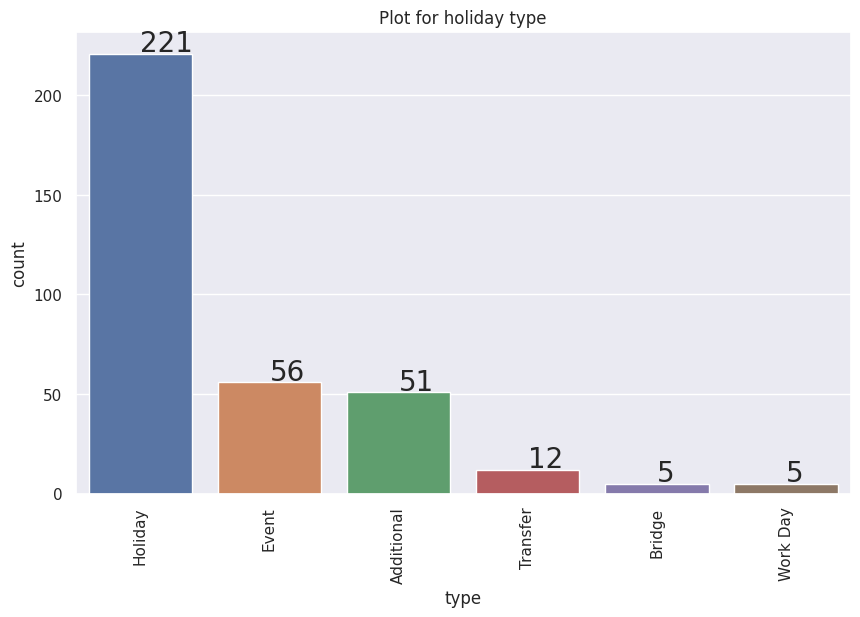

In [121]:
plt.figure(figsize=(10, 6))
x=holidays_type_df['type']
y=holidays_type_df['count']
sns.barplot(x=x, y=y)
for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20))
plt.title('Plot for holiday type')
plt.xticks(rotation=90)
plt.show()

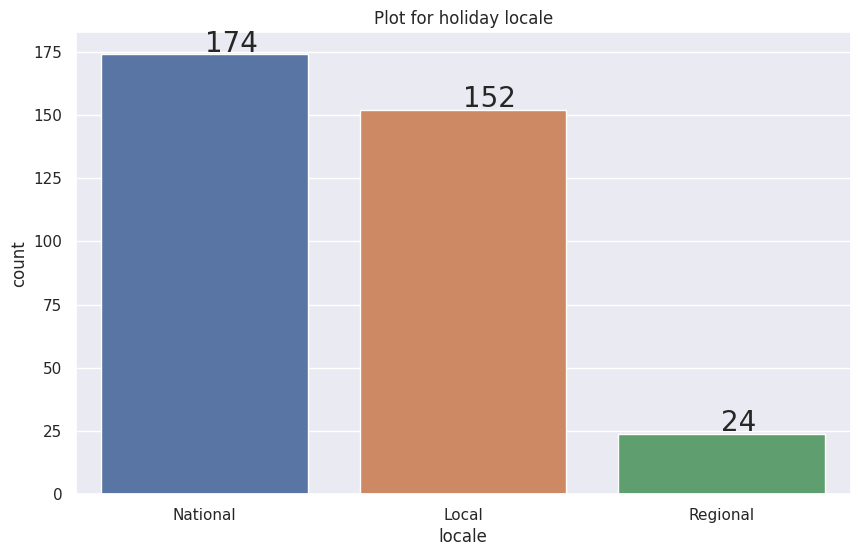

In [123]:
plt.figure(figsize=(10, 6))
x=holidays_local_df['locale']
y=holidays_local_df['count']
sns.barplot(x=x, y=y)
for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20))
plt.title('Plot for holiday locale')
plt.show()

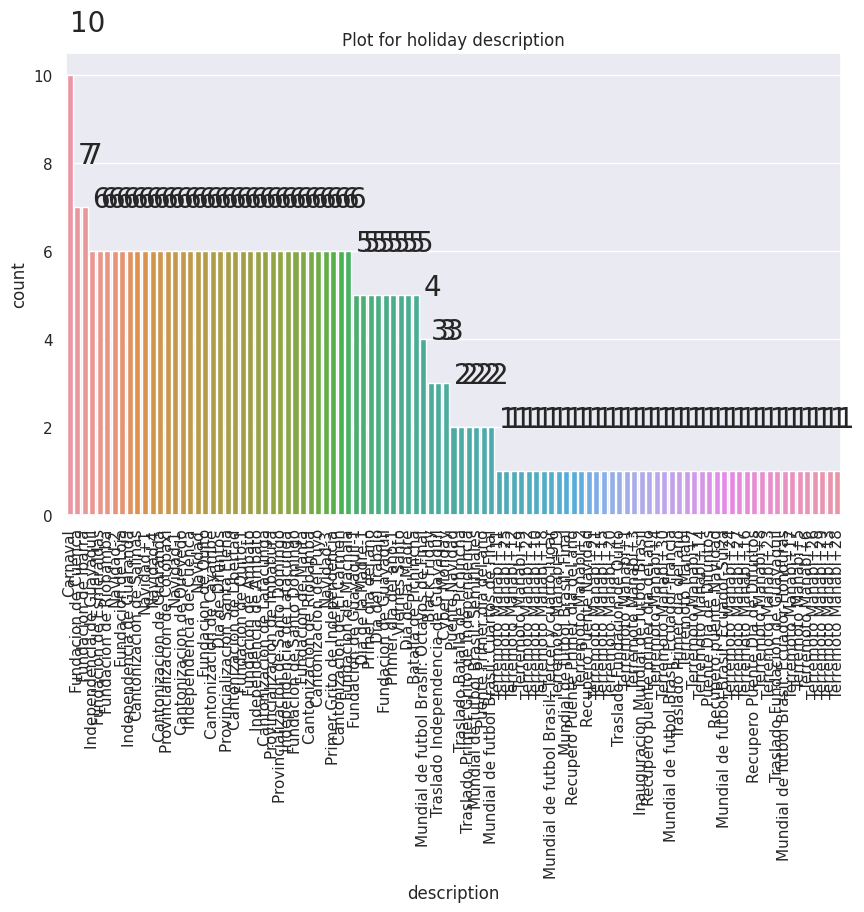

In [125]:
plt.figure(figsize=(10, 6))
x=holidays_desc_df['description']
y=holidays_desc_df['count']
sns.barplot(x=x, y=y)
for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20))
plt.title('Plot for holiday description')
plt.xticks(rotation=90)
plt.show()

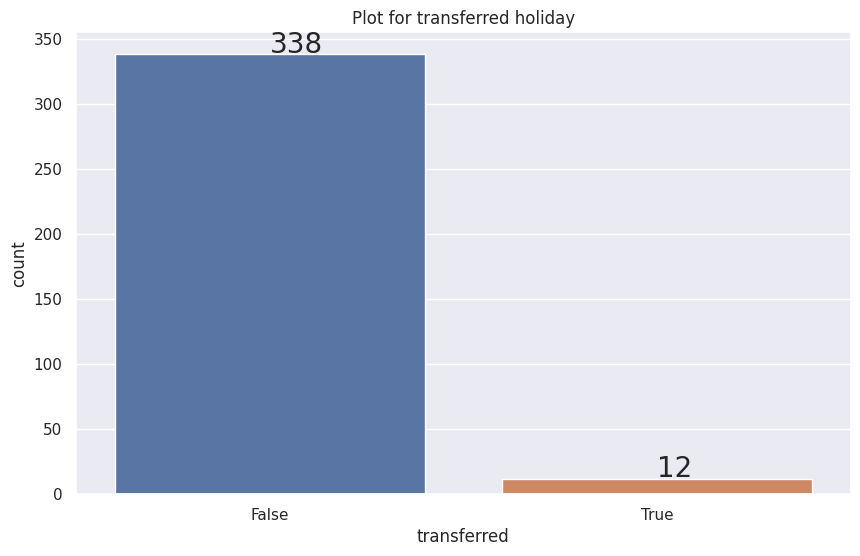

In [127]:
plt.figure(figsize=(10, 6))
x=holidays_transf_df['transferred']
y=holidays_transf_df['count']
sns.barplot(x=x, y=y)
for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20))
plt.title('Plot for transferred holiday')
plt.show()

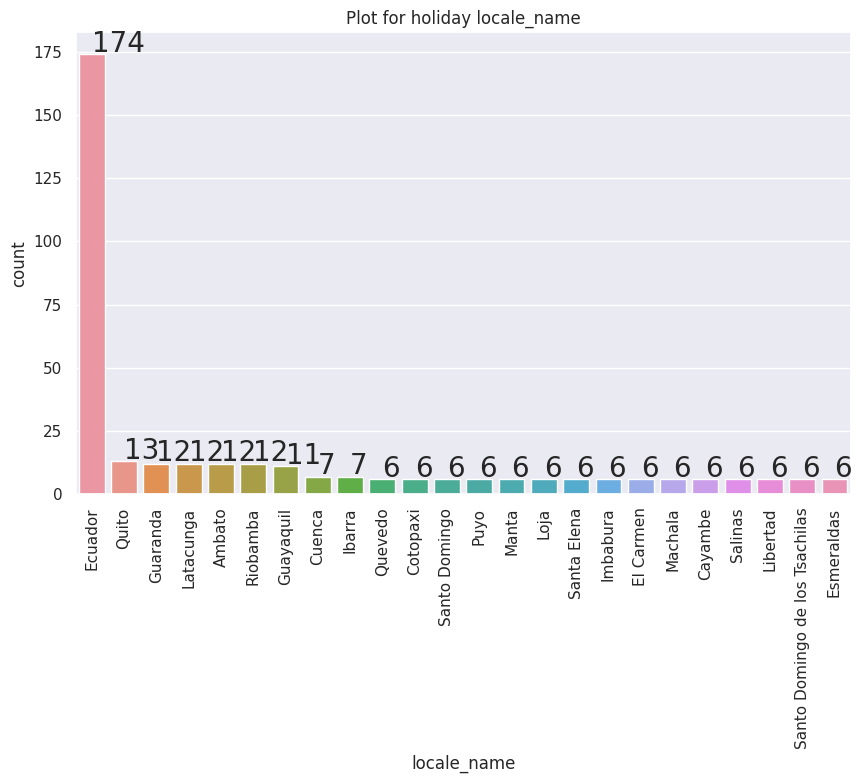

In [128]:
plt.figure(figsize=(10, 6))
x=holidays_locnam_df['locale_name']
y=holidays_locnam_df['count']
sns.barplot(x=x, y=y)
for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20))
plt.title('Plot for holiday locale_name')
plt.xticks(rotation=90)
plt.show()

主要要點：
1. 大多數假期類型都是全國性的和地方性的。
2. 狂歡節假期數量最多
3. 假期轉移的情況很少。

Let's dig more on this transferred holiday type

In [11]:
spark.sql('select transferred, type, count(1) as count FROM holidays_data GROUP BY transferred, type ORDER BY count').show()

+-----------+----------+-----+
|transferred|      type|count|
+-----------+----------+-----+
|      False|    Bridge|    5|
|      False|  Work Day|    5|
|       True|   Holiday|   12|
|      False|  Transfer|   12|
|      False|Additional|   51|
|      False|     Event|   56|
|      False|   Holiday|  209|
+-----------+----------+-----+



Let us see the number of holidays on yearly basis

In [12]:
holiday_count_yearly = spark.sql('''SELECT EXTRACT(YEAR FROM date) as year, count(1) as count 
                                    FROM holidays_data
                                    GROUP BY year
                                    ORDER BY year''').toPandas()

In [13]:
holiday_count_yearly

,year,count
0,2012,41
1,2013,51
2,2014,67
3,2015,52
4,2016,86
5,2017,53


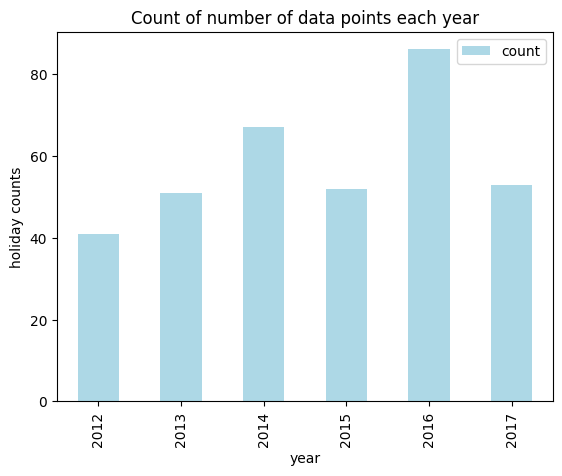

In [14]:
x_labels = holiday_count_yearly['year'].values
fig = holiday_count_yearly[['count']].plot(kind='bar', facecolor='lightblue')
fig.set_xticklabels(x_labels)
fig.set_title('Count of number of data points each year')
fig.set_xlabel('year')
fig.set_ylabel('holiday counts')
plt.show()

2014 and 2016 have a more number of holidays/events compared to other years, let's see why...

In [19]:
holiday_monthly_df = spark.sql('''SELECT EXTRACT(MONTH FROM date) as month, EXTRACT(YEAR FROM date) as year, count(1) as count
                                  FROM holidays_data
                                  GROUP BY month, year
                                  ORDER BY year, month''').toPandas()

In [20]:
holiday_monthly_df

,month,year,count
0,3,2012,1
1,4,2012,4
2,5,2012,1
3,6,2012,4
4,7,2012,3
...,...,...,...
64,8,2017,5
65,9,2017,2
66,10,2017,2
67,11,2017,7


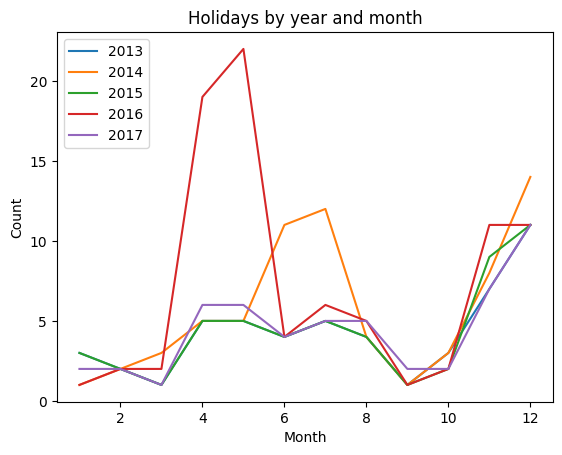

In [21]:
plt.plot(holiday_monthly_df[holiday_monthly_df['year'] == 2013]['month'].values, holiday_monthly_df[holiday_monthly_df['year'] == 2013]['count'].values)
plt.plot(holiday_monthly_df[holiday_monthly_df['year'] == 2014]['month'].values, holiday_monthly_df[holiday_monthly_df['year'] == 2014]['count'].values)
plt.plot(holiday_monthly_df[holiday_monthly_df['year'] == 2015]['month'].values, holiday_monthly_df[holiday_monthly_df['year'] == 2015]['count'].values)
plt.plot(holiday_monthly_df[holiday_monthly_df['year'] == 2016]['month'].values, holiday_monthly_df[holiday_monthly_df['year'] == 2016]['count'].values)
plt.plot(holiday_monthly_df[holiday_monthly_df['year'] == 2017]['month'].values, holiday_monthly_df[holiday_monthly_df['year'] == 2017]['count'].values)
plt.legend(['2013', '2014', '2015', '2016', '2017'], loc='upper left')
plt.title("Holidays by year and month")
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

從中我們可以看出，2016年5月份和2014年7月份，假期數量一如既往地較多，而12月份，由於聖誕節和年終假期，假期數量明顯增加。 讓我們看看 201605 年和 201407 年有什麼

In [22]:
spark.sql('SELECT date, type, description FROM holidays_data WHERE date BETWEEN \'2014-07-01\' AND \'2014-07-31\'').toPandas()

,date,type,description
0,2014-07-01,Event,Mundial de futbol Brasil: Octavos de Final
1,2014-07-03,Holiday,Cantonizacion de El Carmen
2,2014-07-03,Holiday,Fundacion de Santo Domingo
3,2014-07-04,Event,Mundial de futbol Brasil: Cuartos de Final
4,2014-07-05,Event,Mundial de futbol Brasil: Cuartos de Final
5,2014-07-08,Event,Mundial de futbol Brasil: Semifinales
6,2014-07-09,Event,Mundial de futbol Brasil: Semifinales
7,2014-07-12,Event,Mundial de futbol Brasil: Tercer y cuarto lugar
8,2014-07-13,Event,Mundial de futbol Brasil: Final
9,2014-07-23,Holiday,Cantonizacion de Cayambe


In [24]:
spark.sql('SELECT date, type, description FROM holidays_data WHERE date BETWEEN \'2016-05-01\' AND \'2016-05-31\'').toPandas()

,date,type,description
0,2016-05-01,Holiday,Dia del Trabajo
1,2016-05-01,Event,Terremoto Manabi+15
2,2016-05-02,Event,Terremoto Manabi+16
3,2016-05-03,Event,Terremoto Manabi+17
4,2016-05-04,Event,Terremoto Manabi+18
5,2016-05-05,Event,Terremoto Manabi+19
6,2016-05-06,Event,Terremoto Manabi+20
7,2016-05-07,Additional,Dia de la Madre-1
8,2016-05-07,Event,Terremoto Manabi+21
9,2016-05-08,Event,Terremoto Manabi+22


let us look at the mean sales per store by holiday type:

In [30]:
sales_per_store_type = spark.sql('''SELECT date, type, sum(total_sales)/ count(store_nbr) as sales_per_store
        FROM
        (SELECT date, store_nbr, type, sum(unit_sales) as total_sales FROM 
        (SELECT a.date, a.store_nbr, a.unit_sales, b.type FROM (
        (SELECT date, store_nbr, unit_sales FROM data) a
        INNER JOIN (SELECT date, type FROM holidays_data) b 
        ON a.date = b.date))
        GROUP BY date, store_nbr, type ORDER BY date) 
        GROUP BY date, type
        ORDER BY date''').toPandas()

Text(0.5, 1.0, 'Boxplot of mean sales_per_store by holiday type')

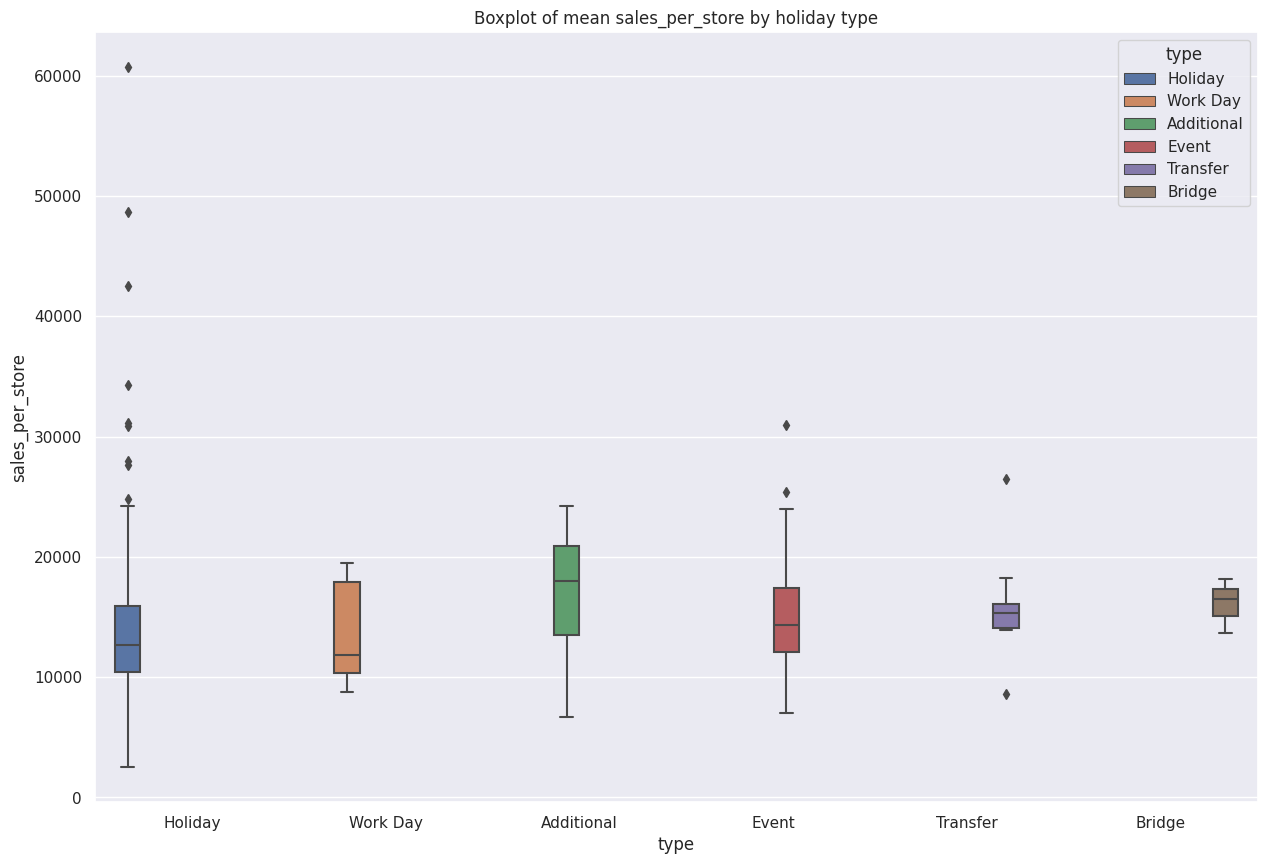

In [31]:
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(x=sales_per_store_type['type'], y = sales_per_store_type['sales_per_store'], hue= sales_per_store_type['type'])
plt.title('Boxplot of mean sales_per_store by holiday type')

EDA 後的結論：

分析後我們看到的主要內容：

1. onpromotion 欄位中看到的缺失值是未追蹤促銷活動的最初幾天。
2. 銷售額逐年呈現上升趨勢，但這是因為商品數量增加，如果我們看一年的整體銷售額，我們的訊號似乎接近平穩。
3. 訓練資料中共有 4036 個項目，宇宙中的總體項目為 4100，因此測試中存在不屬於訓練的項目。
4. 對於商品-商店組合數據，並非全天可用，或者簡單地說，並非所有商品每天都在所有商店出售。
5. 對於最近新增的新項目，我們可能沒有足夠的資料點進行訓練。
6. 店舖總數為54家，其中店數最多的店舖很少，Pichincha和Guayas的店數和銷售額也最多。
7.基多本身貢獻了70%以上的銷售額。
8. 如果我們看物品級別，我們共有 33 個物品系列、337 個類別，其中 24% 的物品是易腐爛的。
9. 大多數商品屬於普通類別，例如雜貨、飲料、清潔、農產品、乳製品。 此外，班級是家庭的子群體。
10. 如果我們嘗試繪製項目的訊號，我們會看到一些項目具有季節性影響和週期性影響。 趨勢並不明顯，但繪製的樣本太小，無法對趨勢做出結論。
11. 從交易水準來看，聖誕節前的交易水準出現大幅上漲，而當商店可能在假期期間關門時，交易水準就會相應下降。 總體而言，整個時間範圍內的銷售額似乎保持穩定。
12. 重要的一點是交易總數近似服從泊松分佈。
13. 油價下跌似乎對銷量沒有任何影響，從銷量圖中可以看出，油價下跌對銷量沒有任何關係，所以我們可以說這個特徵或數據沒有任何影響。對我們很重要，在建模過程中不會考慮。
14. 由於足球世界盃和地震，我們在 2014 年和 2016 年看到大量假期活動。
15. 當比較基於假日類型的每家商店的平均銷售額時，可以看到各組之間存在一些差異的跡象，也可以看到明顯的異常點。

現在我們已經完成了 EDA，我們可以開始資料處理和特徵生成。 詳細的 EDA 以及程式碼片段可以在此處找到。

我們將在本部落格的下一部分中致力於資料收集、特徵生成和建模。